# Не бит, не крашен

**Описание проекта**:

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. Нужно построить модель, которая умеет её определять. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
 - качество предсказания;
 - время обучения модели;
 - время предсказания модели.

**Описание данных**:

Признаки:
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Целевой признак:
- `Price` — цена (евро)

## Подготовка данных

### Загрузка и обзор данных

Загрузим необходимые библитеки, сохраним датасет, сделаем общий обзор данных

In [6]:
# импортируем библиотеки

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyRegressor

# загружаем класс pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# загружаем классы для подготовки данных
from sklearn.preprocessing import ( 
        OneHotEncoder,
        OrdinalEncoder,
        TargetEncoder
)
from category_encoders import TargetEncoder
# библиотеки для градиентного бустинга
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

# для корреляции
from phik import phik_matrix
from phik.report import plot_correlation_matrix

In [7]:
# константы
RANDOM_STATE = 333

In [8]:
#загружаем и сохраняем данные
try:
    df_autos = pd.read_csv('autos.csv')
except:
    df_autos = pd.read_csv('/datasets/autos.csv')

In [9]:
df_autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [10]:
df_autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [11]:
df_autos.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [12]:
df_autos.describe(include = 'object').T

,count,unique,top,freq
DateCrawled,354369,271174,2016-03-24 14:49:47,7
VehicleType,316879,8,sedan,91457
Gearbox,334536,2,manual,268251
Model,334664,250,golf,29232
FuelType,321474,7,petrol,216352
Brand,354369,40,volkswagen,77013
Repaired,283215,2,no,247161
DateCreated,354369,109,2016-04-03 00:00:00,13719
LastSeen,354369,179150,2016-04-06 13:45:54,17


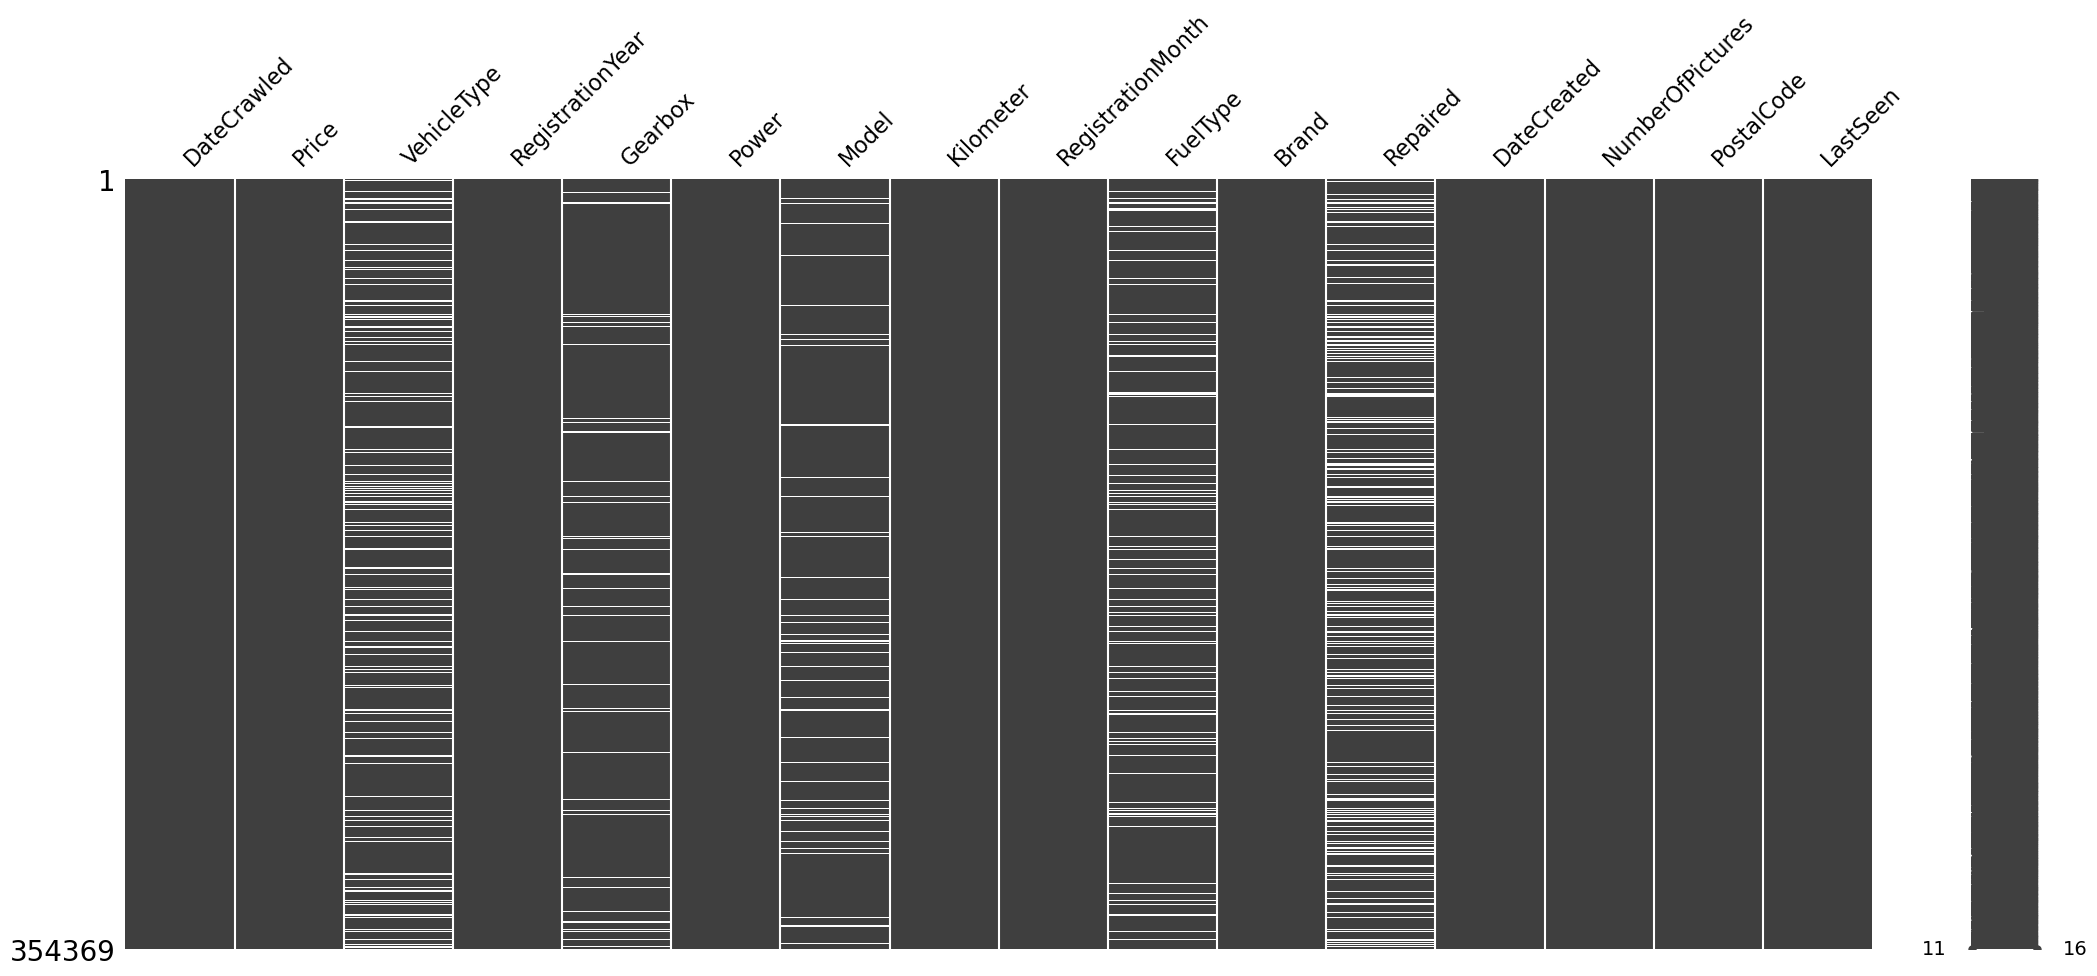

In [13]:
#оценим где попадаются пропуски
msno.matrix(df_autos)
plt.show()

In [14]:
# оцени кол-во пропусков
df_autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [15]:
# кол-во явных дубликатов
df_autos.duplicated().sum()

4

In [16]:
# проверим уникальные значения на наличие невяных дубликатов
df_autos['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [17]:
df_autos['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [18]:
df_autos['FuelType'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

In [19]:
df_autos['Brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

In [20]:
df_autos['Repaired'].sort_values().unique()

array(['no', 'yes', nan], dtype=object)

Вывод:
- не совсем корректное название столбцов
- тип данных даты и времени можно изменить на datetime
- много пропусков
- попадаются явные дубликаты
- есть аномальные значения

### Функции 

In [23]:
# создадим ф-ю для построения гистрограммы и диаграммы размаха
def build_hist_box(df, name_column):
    
    # создаим поля для для гистрограммы и диаграммы размаха
    fig, ax = plt.subplots(2, 1, figsize=(18, 7), sharex=True, gridspec_kw=dict(height_ratios=[5,1]))

    # построим гистограмму
    sns.histplot(data = df, x = name_column, kde=True, ax = ax[0], bins = 50).set(
    title=f'Признак {name_column}',
    xlabel=name_column
    )

    # диграмма размаха 
    sns.boxplot(x = df[name_column], ax = ax[1]).set(xlabel = name_column)
    plt.show()
    

In [24]:
# создадим функцию для построения столбчатых диграмм
def build_barplot(df, name_column):
    plt.figure(figsize = (15,6))
    sns.countplot(data = df,
                  x = name_column,
                  hue= name_column,
                  order = df[name_column].value_counts(ascending=False).index).\
                  set(
                      title=f'Признак {name_column}',
                      xlabel=name_column)

In [25]:
# создадим функцию для заполнения пропусков
def fill_pass(df, name_column, name_pass):
    df_filter.loc[df[name_column].isna() == True, name_column] = name_pass

### Предобработка и исследовательский анализ данных

Изменим названия столбцов, обаботаем дубликаты, изменим тип данных на datetime, посмотрим что можно сделать с пропусками и аномальными значениями. Визуально оценим распределения данных различными графиками.

In [28]:
df_autos.columns = df_autos.columns.str.replace(r'([a-z])([A-Z])', r'\1_\2', regex=True).str.lower()   

In [29]:
df_autos.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [30]:
# кол-во дубликатов
df_autos.duplicated().sum()

4

In [31]:
df_autos.shape

(354369, 16)

Так как дубликтов всего 4, а данных достаточно много(354369), удалим повотряющися строки.

In [33]:
df_autos = df_autos.drop_duplicates()

In [34]:
df_autos.duplicated().sum()

0

In [35]:
df_autos.shape

(354365, 16)

In [36]:
df_autos.dtypes

date_crawled          object
price                  int64
vehicle_type          object
registration_year      int64
gearbox               object
power                  int64
model                 object
kilometer              int64
registration_month     int64
fuel_type             object
brand                 object
repaired              object
date_created          object
number_of_pictures     int64
postal_code            int64
last_seen             object
dtype: object

Изменим тип даннных c `object` на `datetime` у столбцов c `date_crawled`, `date_created` и `last_seen`.

In [38]:
for i in ['date_crawled', 'date_created', 'last_seen']:
    df_autos[i]= pd.to_datetime(df_autos[i], format='%Y-%m-%d %H:%M:%S')

In [39]:
df_autos.dtypes

date_crawled          datetime64[ns]
price                          int64
vehicle_type                  object
registration_year              int64
gearbox                       object
power                          int64
model                         object
kilometer                      int64
registration_month             int64
fuel_type                     object
brand                         object
repaired                      object
date_created          datetime64[ns]
number_of_pictures             int64
postal_code                    int64
last_seen             datetime64[ns]
dtype: object

#### `date_crawled`

Исследуем дату скачивания анкет из базы.

In [42]:
df_autos.date_crawled.describe().to_frame()

,date_crawled
count,354365
mean,2016-03-21 12:58:09.520460544
min,2016-03-05 14:06:22
25%,2016-03-13 11:52:33
50%,2016-03-21 17:50:55
75%,2016-03-29 14:37:20
max,2016-04-07 14:36:58


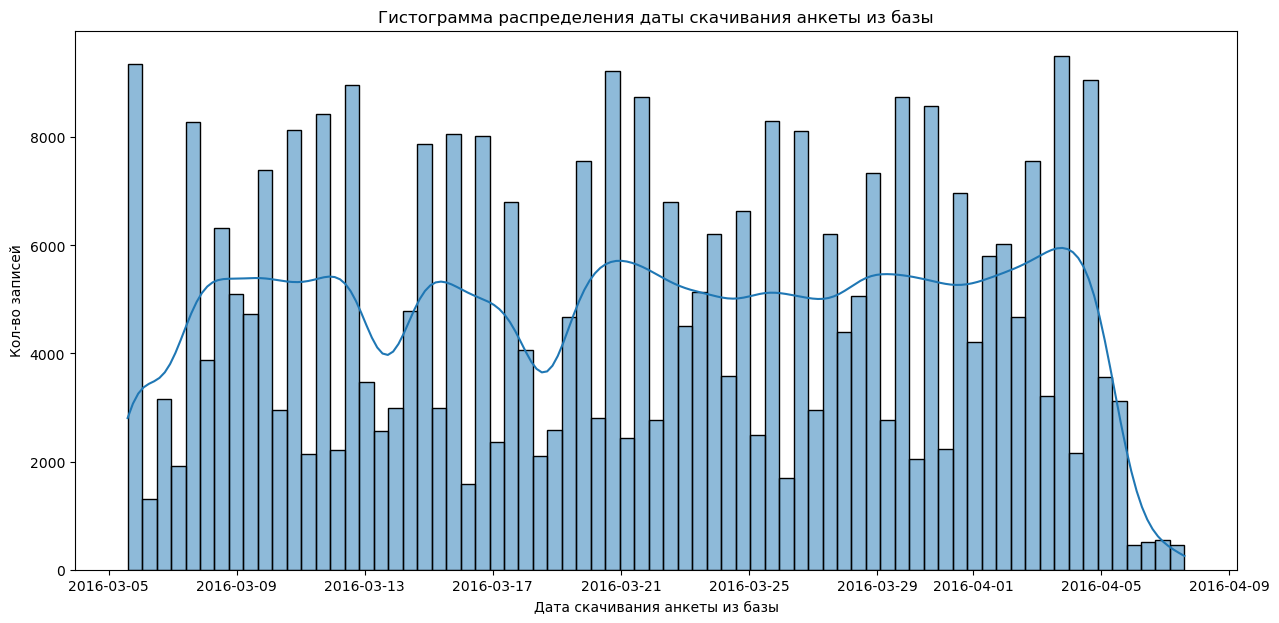

In [43]:
plt.figure(figsize = (15,7))
sns.histplot(data = df_autos, x = 'date_crawled', kde=True).set(
    title='Гистограмма распределения даты скачивания анкеты из базы',
    xlabel='Дата скачивания анкеты из базы',
    ylabel='Кол-во записей'
)
plt.show()

In [44]:
df_autos['date_crawled'].max() - df_autos['date_crawled'].min()

Timedelta('33 days 00:30:36')

Распределение случайно, в какие то дни было скачено больше данных, в какие-то меньше. Данные были скачены за 33 дня 2016 года начиная с марта по апрель. В целом ничего особенного не наблюдается.

#### `price`

Посмотрим на распределение целевого признака.

In [48]:
df_autos.price.describe().to_frame()

,price
count,354365.000000
mean,4416.679830
std,4514.176349
min,0.000000
25%,1050.000000
50%,2700.000000
75%,6400.000000
max,20000.000000


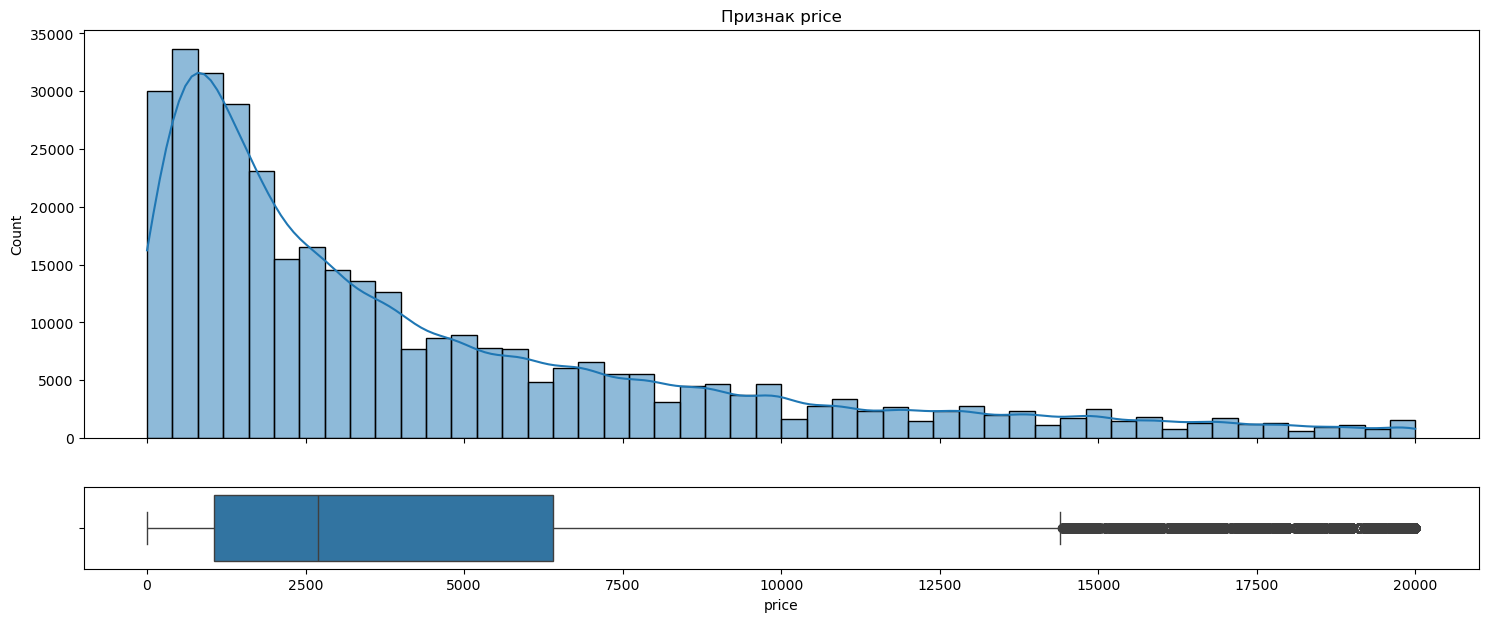

In [49]:
# вызовим ф-ю build_hist_box()
build_hist_box(df_autos, 'price')

Нулевая цена явна не может быть, скорей всего ошибка при скачивании данных, либо сыграл человеский фактор, возможно специально указывают такую цену для привлечения большего внимания. Слишком низкая цена вполне может быть, когда машина больше годна на металлом, нежели для комфортной и безопастной езды. Попадаются цены меньше 100 евро, что в принципен очень странно, конечно в 2016 году был другой ценовой рынок, но я думаю врядли кто-то мог продавать машину за 10 евро(720 рублей в 2016 году), больше можно получить, если сдать на металлом. Поэтому думаю такие данные лучше не учитывать.

Что касается слишком высоких цен, они вполне реальны, но на общем фоне кажутся выбросами. Возможно это машины высокого качества в хорошем состоянии, либо просто человек ошибся при заполнении цены.

Посмотрим по брендам и моделям машины медианное значение цены.

In [51]:
# отсортируем по бренду и модели машины их медианное значение цены
df_autos.pivot_table(index = ['brand', 'model'], values = 'price', aggfunc = 'median').sort_values(by = 'price')

price
brand         model              
lada          samara        300.0
daihatsu      move          500.0
lancia        elefantino    550.0
ford          escort        550.0
rover         defender      550.0
...                           ...
audi          q5          16499.0
              a5          16500.0
mercedes_benz glk         17850.0
audi          q3          18150.0
mercedes_benz gl          18999.0

[297 rows x 1 columns]

В целом логика прослеживается, высокие цены за машины дорогих брендов и моделей, и низкие цены за бюджетные модели. 

Думаю высокие цены можно оставить, а вот слишком низкие явно походят на выбросы. Попробуем удалять различный % данных, но только для низких цен. В данном случае наша мотивация избавиться от такой цены, действительно, в том, чтобы не обучать модель ее предсказывать. Это сомнительно - клиент, не готовый отдавать что-то совсем даром, вряд ли будет рад увидеть такую оценку для своего автомобиля.

In [53]:
# методом quantile() удалим % данных с низкимы ценами
df_filter = df_autos[(df_autos['price'] >= df_autos['price'].quantile(0.04))]

In [54]:
df_filter.price.describe().to_frame()

,price
count,341051.000000
mean,4588.887026
std,4514.862284
min,100.000000
25%,1200.000000
50%,2900.000000
75%,6500.000000
max,20000.000000


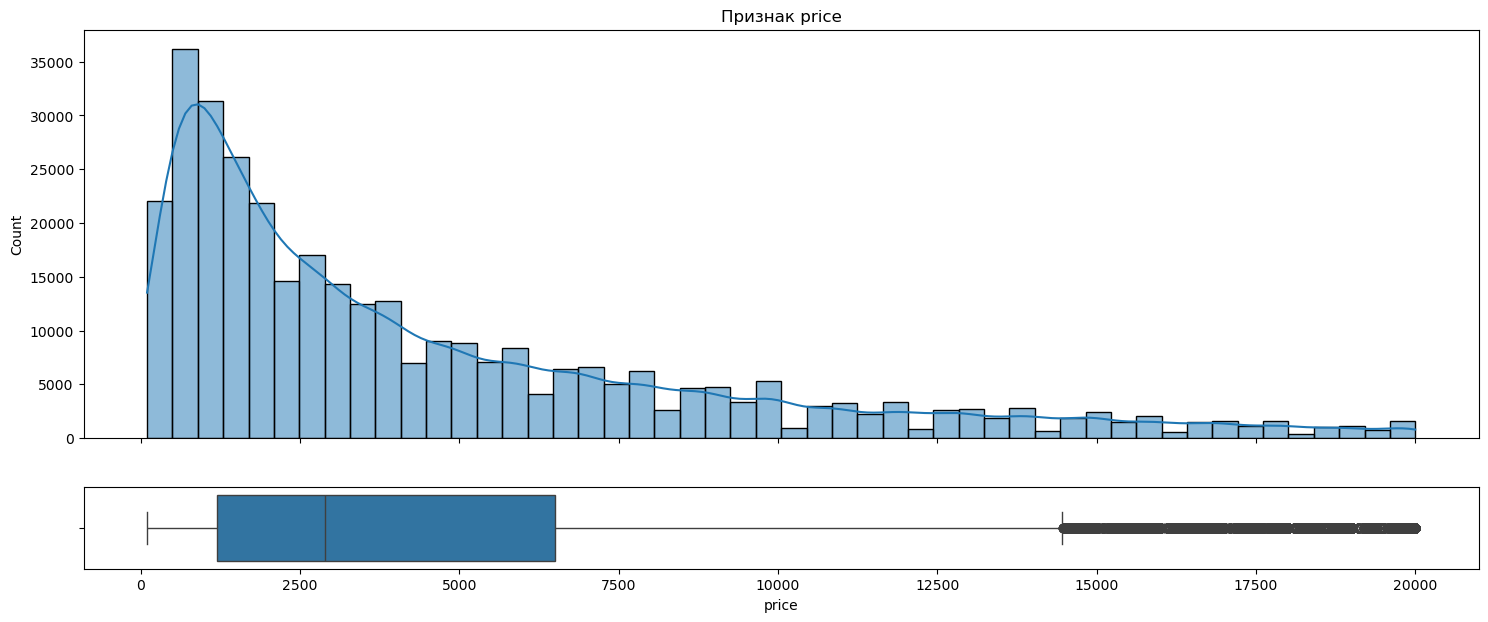

In [55]:
# вызовим ф-ю build_hist_box()
build_hist_box(df_filter, 'price')

Распределение в целом осталось такое же, цены стали больше походить на правду. Возможно мы могли удалить какие то отдельные модели, марки... или потерять слишком большой процент таких машин, проверим это.

In [57]:
for i in ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']:
    print(f'Было уникальных значений {len(df_autos[i].unique())}, стало {len(df_filter[i].unique())}')

Было уникальных значений 9, стало 9
Было уникальных значений 3, стало 3
Было уникальных значений 251, стало 251
Было уникальных значений 8, стало 8
Было уникальных значений 40, стало 40
Было уникальных значений 3, стало 3


После удаления выбросов все осталось как было. Посмотрим какой процент удалили некоторых данных.

In [59]:
diff_repaired = df_autos.repaired.value_counts().to_frame().merge(df_filter.repaired.value_counts().to_frame(), on='repaired')
diff_repaired['difference'] = 100 - ((diff_repaired['count_y'] / diff_repaired['count_x']) * 100)
diff_repaired.sort_values(by = 'difference', ascending = False)

,count_x,count_y,difference
repaired,,,
yes,36053,33491,7.106205
no,247158,243203,1.600191


In [60]:
diff_fuel_type = df_autos.fuel_type.value_counts().to_frame().merge(df_filter.fuel_type.value_counts().to_frame(), on='fuel_type')
diff_fuel_type['difference'] = 100 - ((diff_fuel_type['count_y'] / diff_fuel_type['count_x']) * 100)
diff_fuel_type.sort_values(by = 'difference', ascending = False)

,count_x,count_y,difference
fuel_type,,,
other,204,154,24.509804
electric,90,87,3.333333
petrol,216349,209595,3.121808
hybrid,233,226,3.004292
lpg,5310,5155,2.919021
cng,565,549,2.831858
gasoline,98719,96936,1.806137


In [61]:
diff_model = df_autos.model.value_counts().to_frame().merge(df_filter.model.value_counts().to_frame(), on='model')
diff_model['difference'] = 100 - ((diff_model['count_y'] / diff_model['count_x']) * 100)
diff_model.sort_values(by = 'difference', ascending = False).head(20)

,count_x,count_y,difference
model,,,
serie_1,2,1,50.000000
serie_3,4,3,25.000000
911,84,67,20.238095
amarok,16,13,18.750000
601,419,349,16.706444
move,60,50,16.666667
samara,13,11,15.384615
calibra,217,188,13.364055
q3,15,13,13.333333


In [62]:
diff_gearbox = df_autos.gearbox.value_counts().to_frame().merge(df_filter.gearbox.value_counts().to_frame(), on='gearbox')
diff_gearbox['difference'] = 100 - ((diff_gearbox['count_y'] / diff_gearbox['count_x']) * 100)
diff_gearbox.sort_values(by = 'difference', ascending = False)

,count_x,count_y,difference
gearbox,,,
manual,268249,260072,3.048287
auto,66283,64665,2.441048


In [63]:
diff_vehicle_type = df_autos.vehicle_type.value_counts().to_frame().merge(df_filter.vehicle_type.value_counts().to_frame(), on='vehicle_type')
diff_vehicle_type['difference'] = 100 - ((diff_vehicle_type['count_y'] / diff_vehicle_type['count_x']) * 100)
diff_vehicle_type.sort_values(by = 'difference', ascending = False)

,count_x,count_y,difference
vehicle_type,,,
other,3288,3048,7.299270
coupe,16161,15553,3.762143
small,79830,77443,2.990104
wagon,65165,63464,2.610297
sedan,91457,89087,2.591382
suv,11996,11762,1.950650
convertible,20203,19817,1.910607
bus,28775,28265,1.772372


In [64]:
diff_brand = df_autos.brand.value_counts().to_frame().merge(df_filter.brand.value_counts().to_frame(), on='brand')
diff_brand['difference'] = 100 - ((diff_brand['count_y'] / diff_brand['count_x']) * 100)
diff_brand.sort_values(by = 'difference', ascending = False)

,count_x,count_y,difference
brand,,,
sonstige_autos,3374,2700,19.976289
trabant,589,475,19.354839
porsche,758,705,6.992084
rover,486,456,6.172840
chrysler,1439,1354,5.906880
lada,225,212,5.777778
daihatsu,806,761,5.583127
subaru,762,722,5.249344
lancia,471,449,4.670913


В целом нет каких то значительных потерь.

#### `vehicle_type`

Происследуем тип кузова машин. Так как мы удалили выбросы из столбца `price`, у нас получился новый датасет с очищенными даннымы, будем использвовать его `df_filter`.

In [68]:
# посмотрим в процентном соотношении распределения типов кузовов
df_filter['vehicle_type'].value_counts(dropna = False, normalize = True)

vehicle_type
sedan          0.261213
small          0.227072
wagon          0.186084
NaN            0.095622
bus            0.082876
convertible    0.058106
coupe          0.045603
suv            0.034488
other          0.008937
Name: proportion, dtype: float64

In [69]:
df_filter['vehicle_type'].value_counts().to_frame().reset_index()

,vehicle_type,count
0,sedan,89087
1,small,77443
2,wagon,63464
3,bus,28265
4,convertible,19817
5,coupe,15553
6,suv,11762
7,other,3048


In [70]:
# оцени медианное значение цены на машины для разных типов кузовов
df_filter.pivot_table(index = 'vehicle_type', values = 'price', aggfunc = 'median').sort_values(by = 'price', ascending = False)

,price
vehicle_type,
suv,8600.0
convertible,5500.0
bus,4300.0
coupe,4200.0
wagon,3300.0
sedan,3100.0
other,2500.0
small,1600.0


У каждого типа кузова свои особенности, соответсвенно и цена будет отличаться.

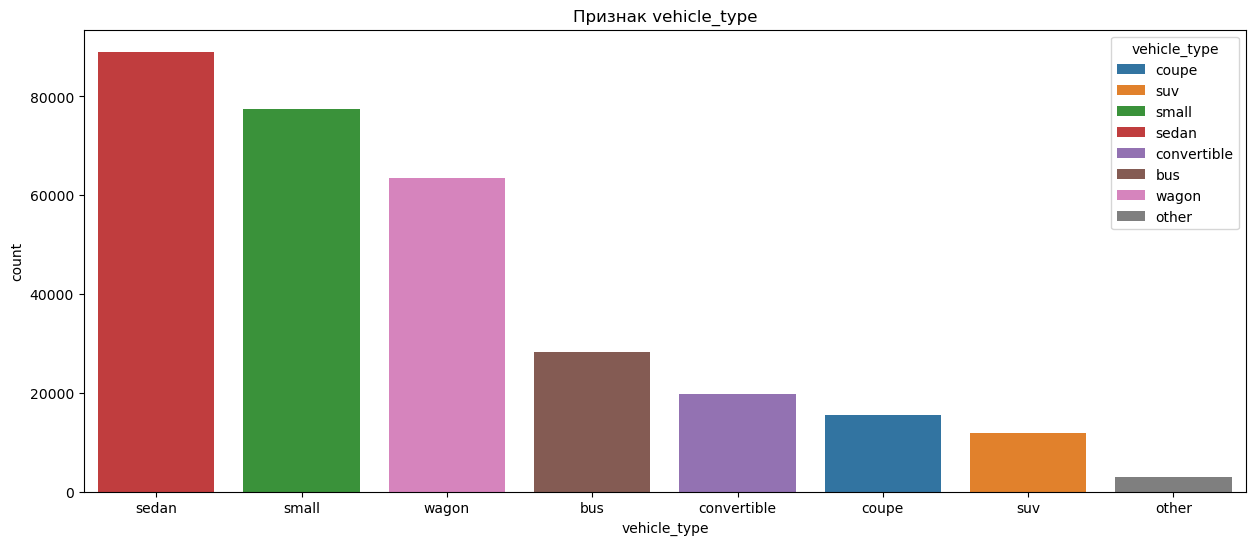

In [72]:
build_barplot(df_filter, 'vehicle_type')

Здесь у нас примерно 10% пропусков, которые нужно чем-то заменить.

Sedan преобладает, но не значительно. Заменить пропуски 'Sedan' не совсем верно, так как можно сильно исказить данные.

Как вариант, можно сначала обработать модель, а потом на основе модели заполнять пропуски в типе кузова. Чтобы заполнение было чуть чище, модель при заполнении можно учитывать только в тех случаях, где она изначально была известна, а в оставшихся пропусках в типе кузова уже поместить заглушку или заполнить модой в соответсвии бренда машины.

In [74]:
# для каждой модели и бренда сохраним моду типа кузова
model_vehicle_type = df_filter.groupby('model')['vehicle_type'].apply(lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()
brand_vehicle_type = df_filter.groupby('brand')['vehicle_type'].apply(lambda x: x.mode()[0]).to_dict()

In [75]:
# создадим ф-ю для замены пропусков на моду по модели машины, если у модели машины есть пропуск, заменим модой по бренду
def fill_vehicle_type(row):
    if pd.isna(row['vehicle_type']):
        
        if row['model'] in model_vehicle_type and model_vehicle_type[row['model']] is not None:
            return model_vehicle_type[row['model']]
            
        elif row['brand'] in brand_vehicle_type:
            return brand_vehicle_type[row['brand']]
        
    return row['vehicle_type']

In [76]:
# заменим пропуски на значение моды
df_filter['vehicle_type'] = df_filter.apply(fill_vehicle_type, axis = 1)

C:\Users\кц\AppData\Local\Temp\ipykernel_4248\4109978962.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['vehicle_type'] = df_filter.apply(fill_vehicle_type, axis = 1)


In [77]:
df_filter['vehicle_type'].isna().sum()

0

In [78]:
# посмотрим в процентном соотношении распределения типов кузовов
df_filter['vehicle_type'].value_counts(dropna = False, normalize = True)

vehicle_type
sedan          0.306670
small          0.256009
wagon          0.196015
bus            0.091294
convertible    0.058742
coupe          0.046521
suv            0.035804
other          0.008946
Name: proportion, dtype: float64

После пропусков незначительно вырос процент типа кузова sedan, small.

#### `registration_year`

Посмотрим на года регистрации машин. Будем использовать датасет `df_filter` очищенныей от выбросов в столбце `price`.

In [82]:
df_filter.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [83]:
df_filter['registration_year'].describe().to_frame()

,registration_year
count,341051.000000
mean,2003.955335
std,69.812151
min,1000.000000
25%,1999.000000
50%,2003.000000
75%,2008.000000
max,9999.000000


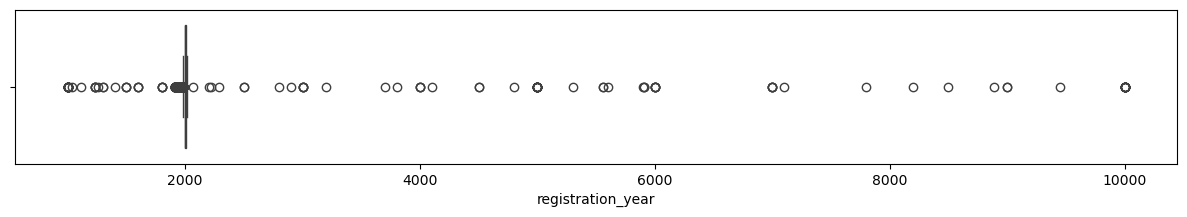

In [84]:
plt.figure(figsize = (15, 2))
sns.boxplot(df_filter['registration_year'], orient = 'h')
plt.show()

Какие-то неарельные года регистрции, явно аномалии, удалим их. 

Данные скачивались за 2016 год, поэтому 2017 год регистрации явно выброс, удалим.


In [86]:
# Удалим данные, где год регистрации больше 2016 года 
df_filter = df_filter[df_filter['registration_year'] < 2017]

In [87]:
df_filter['registration_year'].describe()

count    327364.000000
mean       2002.520085
std          11.843934
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

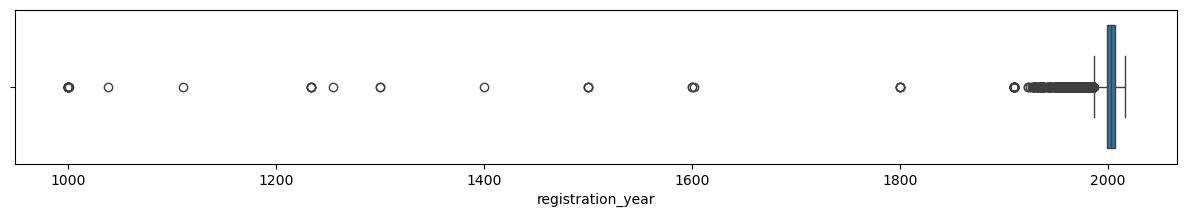

In [88]:
plt.figure(figsize = (15, 2))
sns.boxplot(df_filter['registration_year'], orient = 'h')
plt.show()

C большими годами разобрались остались маленькие. Посмторим, что получилтся еслис оставить 1900 год и больше.

In [90]:
df_filter[df_filter['registration_year'] > 1900]['registration_year'].describe()

count    327321.000000
mean       2002.624766
std           6.860050
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

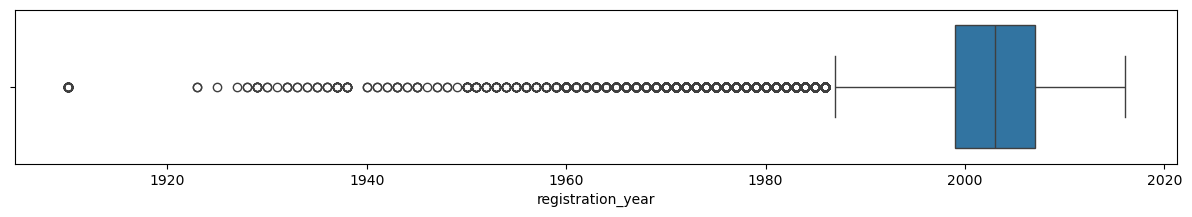

In [91]:
plt.figure(figsize = (15, 2))
sns.boxplot(df_filter[df_filter['registration_year'] > 1900]['registration_year'], orient = 'h')
plt.show()

Первые машины с ДВС появились ещё раньше, так что вполне реальны года.

Также можно задействовать месяц регистрации и тот факт, что последняя выгрузка была сделана в апреле 2016 года.

In [93]:
df_filter = df_filter[df_filter['registration_year'] > 1900]

In [94]:
# cохраним индексы с годом 2016 и месяцем больше 4
false_ads = df_filter[(df_filter['registration_year'] == 2016) & (df_filter['registration_month'] <= 4)].index

In [95]:
# удалим строки где год равен 2016 и месяцем больше 4
df_filter = df_filter[~df_filter.index.isin(false_ads)]

In [96]:
# проверим
df_filter[(df_filter['registration_year'] == 2016) & (df_filter['registration_month'] <= 4)]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen


In [97]:
df_autos.shape

(354365, 16)

In [98]:
df_filter.shape

(322890, 16)

In [99]:
df_filter['registration_year'].describe().to_frame()

,registration_year
count,322890.000000
mean,2002.441218
std,6.724389
min,1910.000000
25%,1999.000000
50%,2003.000000
75%,2007.000000
max,2016.000000


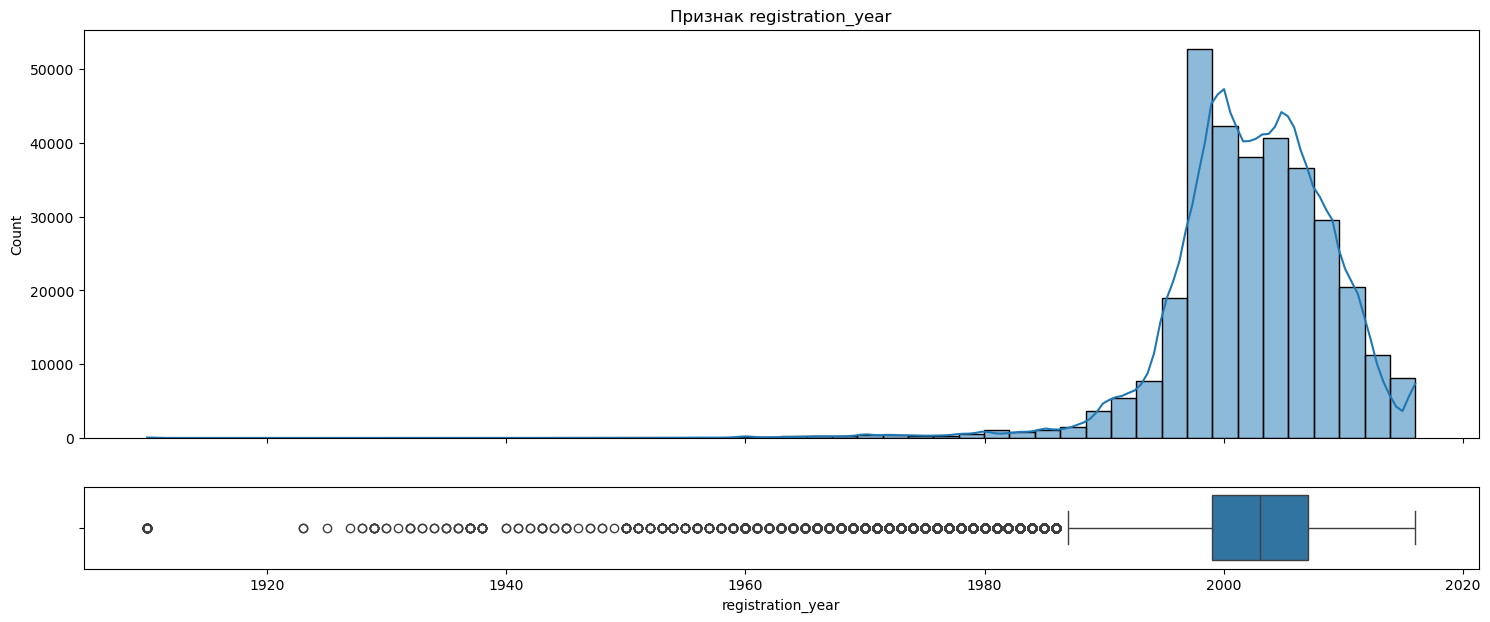

In [100]:
# вызовим ф-ю build_hist_box()
build_hist_box(df_filter, 'registration_year')

In [101]:
df_filter['registration_year'].value_counts().head(10) 

registration_year
2000    22661
1999    21845
2005    21363
2006    19641
2001    19573
2003    19452
2004    19303
2002    18673
1998    17027
2007    16976
Name: count, dtype: int64

Сейчас выглядит правдоподобно, хотя попадаются выбросы, но это скорей всего какие-то старые модели. В основном размещают машины до 2007 года.

In [103]:
# оцени медианное значение цены на машины для разных годов регистрации
df_filter.pivot_table(index = 'registration_year', values = 'price', aggfunc = 'median').sort_values(by = 'price', ascending = False).head(10)

,price
registration_year,
1933,18100.0
1947,18025.0
1927,16500.0
1951,15725.0
1935,14500.0
1936,14000.0
1940,13950.0
2014,13900.0
2015,13600.0


Здесь мы видим интересную картинку, казалось бы чем старше машина, тем цена её должна быть меньше, но видимо старинные машины считаются как раритет.

#### `gearbox`

Посмотрим какой тип коробки передач преобладает. Мы изменили датасет удалив выбросы из столбцов `price` и `registration_year`, дальше будем использовать очищенный датасет `df_filter`.

In [107]:
# посмотрим в процентном соотношении тип коробки передач
df_filter['gearbox'].value_counts(dropna = False, normalize = True)

gearbox
manual    0.764016
auto      0.193255
NaN       0.042730
Name: proportion, dtype: float64

In [108]:
df_filter['gearbox'].describe().to_frame()

,gearbox
count,309093
unique,2
top,manual
freq,246693


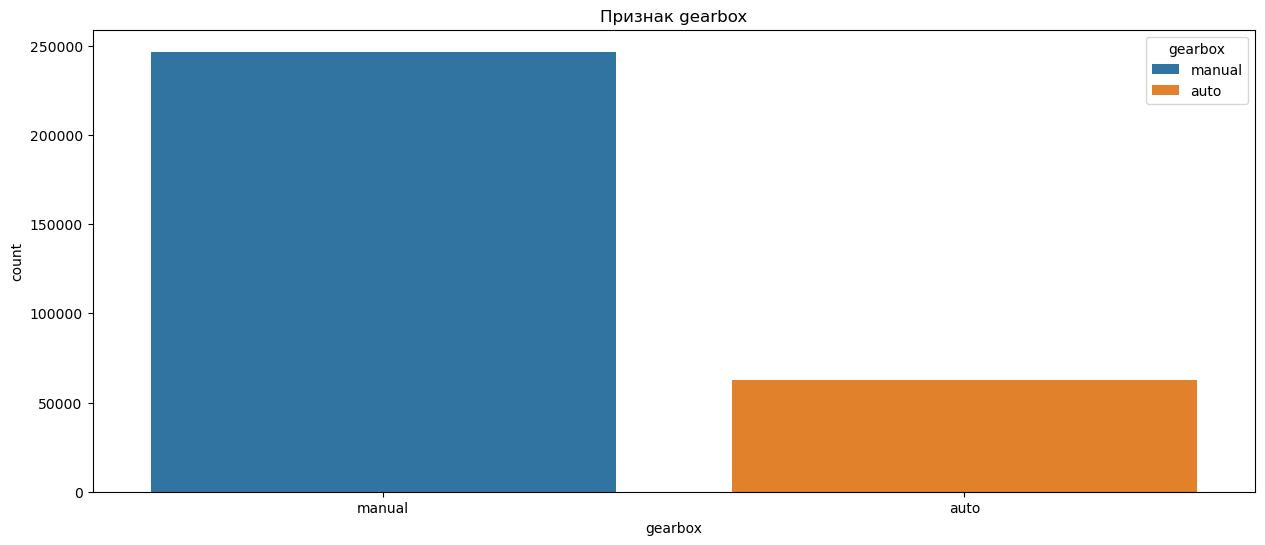

In [109]:
build_barplot(df_filter, 'gearbox')

In [110]:
# оцени медианное значение цены на машины для разных КПП
df_filter.pivot_table(index = 'gearbox', values = 'price', aggfunc = 'median').sort_values(by = 'price', ascending = False)

,price
gearbox,
auto,5800.0
manual,2600.0


Примерно 5% пропусков. В основном машины с механической коробкой передач, но заполянть пропуски только значением 'manual' не рационально, потому что механика и автомат по ценам отличаются и неверное заполнение может предсказывать не совсем точную цену машины.

Здесь, по аналогии с типом кузова, можно было бы проверить взаимосвязь данного признака с моделью и при возможности как-то использовать это при заполнении пропусков.

In [112]:
# создадим сводную таблицу где посмотрим для каждый модели кол-во машин с механической и автоматической КПП
df_filter[df_filter['model'].isna() == False].pivot_table(index = 'model', columns = 'gearbox', values = 'brand', aggfunc = 'count').head(10)

gearbox,auto,manual
model,,
100,59.0,311.0
145,NaN,36.0
147,25.0,478.0
156,42.0,517.0
159,26.0,177.0
1_reihe,71.0,1070.0
1er,409.0,2917.0
200,4.0,12.0
2_reihe,146.0,4321.0


In [113]:
# создадим сводную таблицу где посмотрим для каждый модели кол-во машин с механической и автоматической КПП
df_filter.pivot_table(index = 'brand', columns = 'gearbox', values = 'date_crawled', aggfunc = 'count').head(10)

gearbox,auto,manual
brand,,
alfa_romeo,130.0,1896.0
audi,8085.0,18195.0
bmw,10425.0,22860.0
chevrolet,552.0,1030.0
chrysler,694.0,567.0
citroen,561.0,3935.0
dacia,NaN,840.0
daewoo,32.0,439.0
daihatsu,80.0,601.0


В основном у моделей и брендов преобладает тот или иной вид КПП, а у каких то совсем только один вид КПП. Но у некоторых брендов попадаются примерно одинаковое кол-во как auto, так и manual. Так что постраемся заполнить пропуски модой в соответствии какая КПП преобладает у каждой модели автомобиля. 

In [115]:
model_gearbox = df_filter.groupby('model')['gearbox'].apply(lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()
brand_gearbox = df_filter.groupby('brand')['gearbox'].apply(lambda x: x.mode()[0]).to_dict()

In [116]:
def fill_gearbox(row):
    if pd.isna(row['gearbox']):
        
        if row['model'] in model_gearbox and model_gearbox[row['model']] is not None:
            return model_gearbox[row['model']]
            
        elif row['brand'] in brand_gearbox:
            return brand_gearbox[row['brand']]
            
    return row['gearbox']

In [117]:
df_filter['gearbox'] = df_filter.apply(fill_gearbox, axis = 1)

In [118]:
df_filter['gearbox'].isna().sum()

0

In [119]:
# посмотрим в процентном соотношении тип коробки передач
df_filter['gearbox'].value_counts(dropna = False, normalize = True)

gearbox
manual    0.801809
auto      0.198191
Name: proportion, dtype: float64

От пропусков избавились, доля машин с механической коробкой стало больше.

#### `power`

Происследуем мощность машин. Будем использовать датасет `df_filter`.

In [123]:
df_filter.power.describe().to_frame()

,power
count,322890.000000
mean,112.869544
std,184.007094
min,0.000000
25%,73.000000
50%,105.000000
75%,143.000000
max,20000.000000


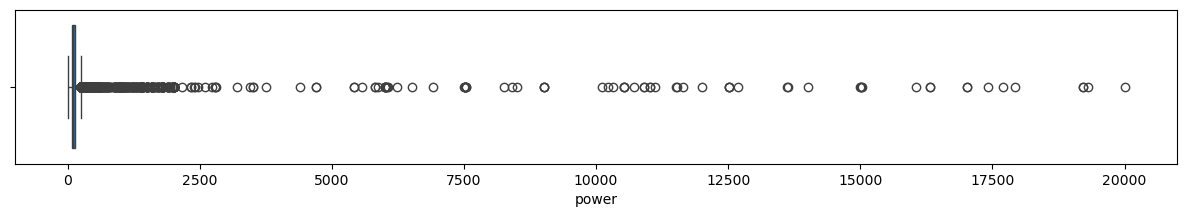

In [124]:
plt.figure(figsize = (15, 2))
sns.boxplot(df_filter['power'], orient = 'h')
plt.show()

Картина не очень. Много выбросов, аномальных значений. Возможно при заполнени, человек просто записал значение мощности без разделителя цифр, и получились такие огромные значения, либо произошла какая-то техническая ошибка при заполнении или скачивании данных и прибивилось несколько лишних нулей. 

Впринципе мощность в диапозоне до 600 л.с. реальна, но вот выше уже сомнительно, хотя такие машины есть, но это совсем другой уровень и больше походит на редкость.

Вообщем можно попробывать уменьшить мощность в 10 и 100 раз, но не понятно для какого диапозона это делать. Проведем ещё доп.исследования.

In [126]:
# оценим медианное максимальное значение по мощности для разных брендов и моделей
df_filter.pivot_table(index = ['brand', 'model'], values = 'power', aggfunc = 'median').sort_values(by = 'power', ascending = False)

,,power
brand,model,
bmw,m_reihe,343.0
porsche,cayenne,340.0
bmw,6er,333.0
mercedes_benz,cl,306.0
porsche,911,300.0
...,...,...
daihatsu,move,42.0
volkswagen,kaefer,34.0
trabant,601,26.0


Значит по медиане максимальная мощность 343 л.с, а минимальная 0 л.с., но это скорей всего так написали в связи с не рабочим двигателем или просто не знали фактическую мощность, будем считать за минимум 26 л.с.

Сложновато понять на что делить, допустим мощность 10 000 л.с. можно поделить на 100 тогда будте 100 л.с., а если взять 4000, то можно поделить и на 10 и на 100 так как 40 л.с и 400 л.с. тоже возможно.

Вообщем делить мощность на 10 или на 100 не совсем хорошая идея, можно только больше запутаться. 

Посмотрим как распределяется мощность машин у разных брендов, оценим максимальные и выделим диапазон.

              power
count  34267.000000
mean     160.973882
std      262.045379
min        0.000000
25%      118.000000
50%      150.000000
75%      192.000000
max    19312.000000


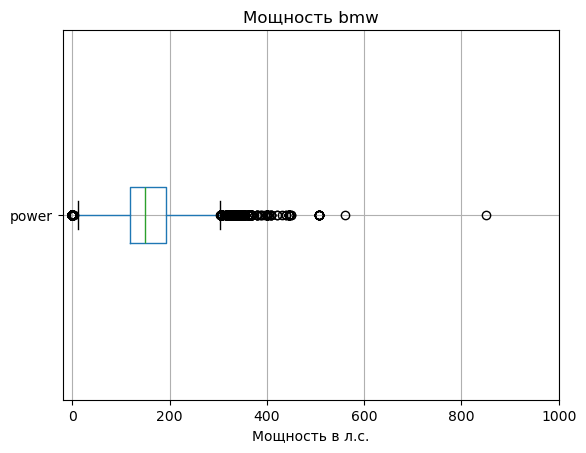

            power
count  696.000000
mean   232.488506
std    114.006512
min      0.000000
25%    168.750000
50%    241.000000
75%    300.000000
max    521.000000


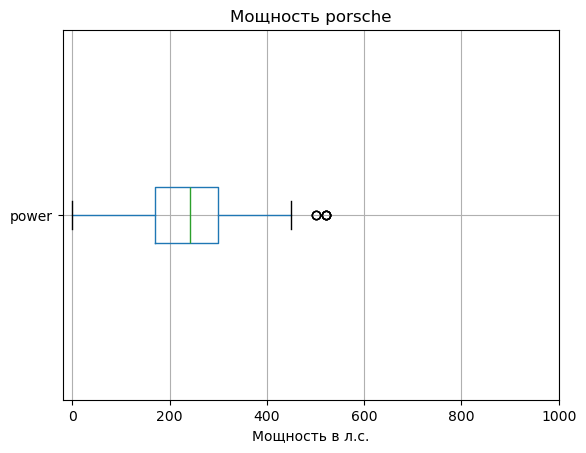

              power
count  29956.000000
mean     147.404226
std      211.968219
min        0.000000
25%      109.000000
50%      143.000000
75%      177.000000
max    20000.000000


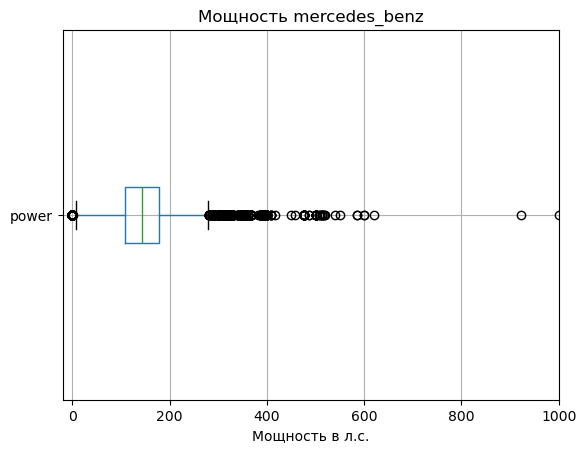

              power
count  69176.000000
mean      97.630869
std      143.341201
min        0.000000
25%       64.000000
50%       98.000000
75%      122.000000
max    12012.000000


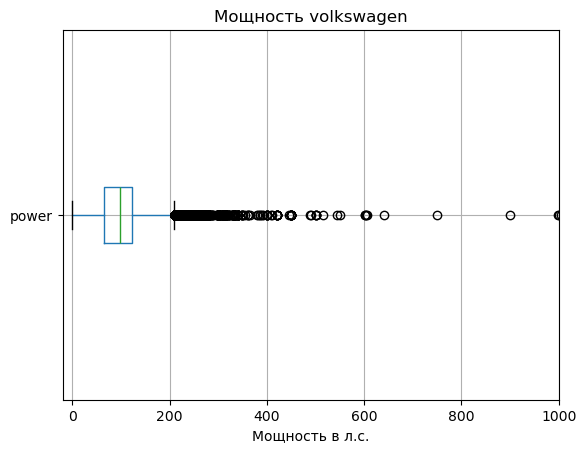

            power
count  480.000000
mean   209.143750
std     91.839893
min      0.000000
25%    169.000000
50%    211.000000
75%    241.000000
max    600.000000


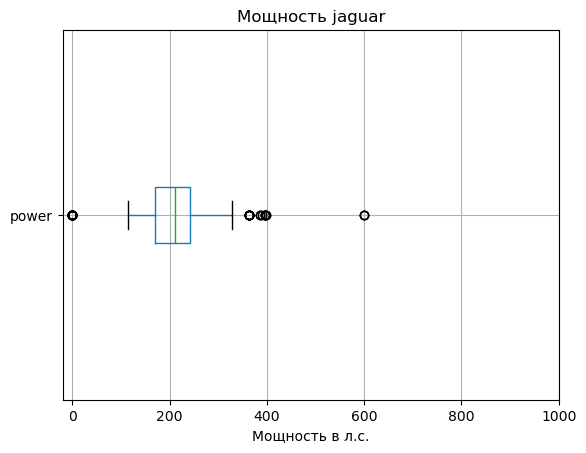

            power
count  202.000000
mean    61.792079
std     34.699941
min      0.000000
25%     60.000000
50%     82.000000
75%     82.000000
max    137.000000


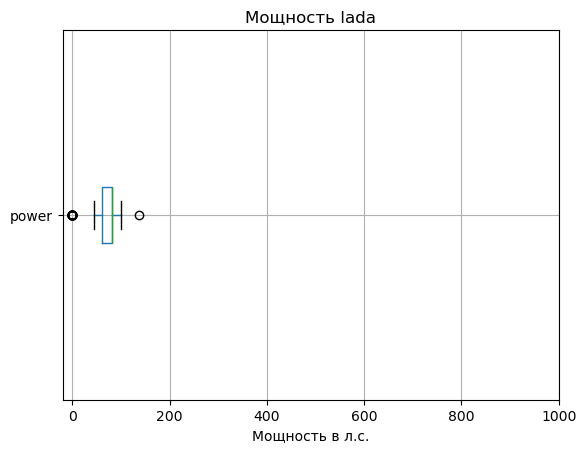

In [128]:
for i in ['bmw', 'porsche', 'mercedes_benz', 'volkswagen', 'jaguar', 'lada']:
    
    print(df_filter[df_filter['brand'] == i][['power']].describe())

    plt.xlim(-20, 1000)
    plt.title(f'Мощность {i}')
    plt.xlabel('Мощность в л.c.')
    df_filter[df_filter['brand'] == i][['power']].boxplot(vert = False)
    plt.show()

Возьмем диапазон  до 600 л.с., впринципе знанчение реально, просто такие автомибили достаточно редкие и не каждый может себе позволить её, поэтому на общем фоне кажется как выброс.

In [130]:
pd.DataFrame(df_filter[df_filter['model'].isna() == False].groupby(['brand', 'model', 'registration_year'])['power'].apply(lambda x: x.median()))\
.sort_values(by = 'power', ascending = False)

power
brand      model   registration_year        
fiat       bravo   2016               5215.5
mini       cooper  1987               3030.0
volkswagen touareg 1992               1992.0
opel       astra   1945               1000.0
renault    espace  1910                999.0
...                                      ...
seat       altea   2001                  0.0
           cordoba 2016                  0.0
           ibiza   1986                  0.0
           other   1986                  0.0
alfa_romeo 145     1960                  0.0

[6084 rows x 1 columns]

Ещё раз убеждаеся, что слишком большие мощности это выбросы, так как mini cooper 1987 года в лучшем случае мог иметь до 100 л.с, да и все остальные модели до 1990 года вряд ли могли иметь мощность больше 900 л.с.

Исключим мощности более 600.

In [132]:
df_filter = df_filter[df_filter['power'] <= 600]

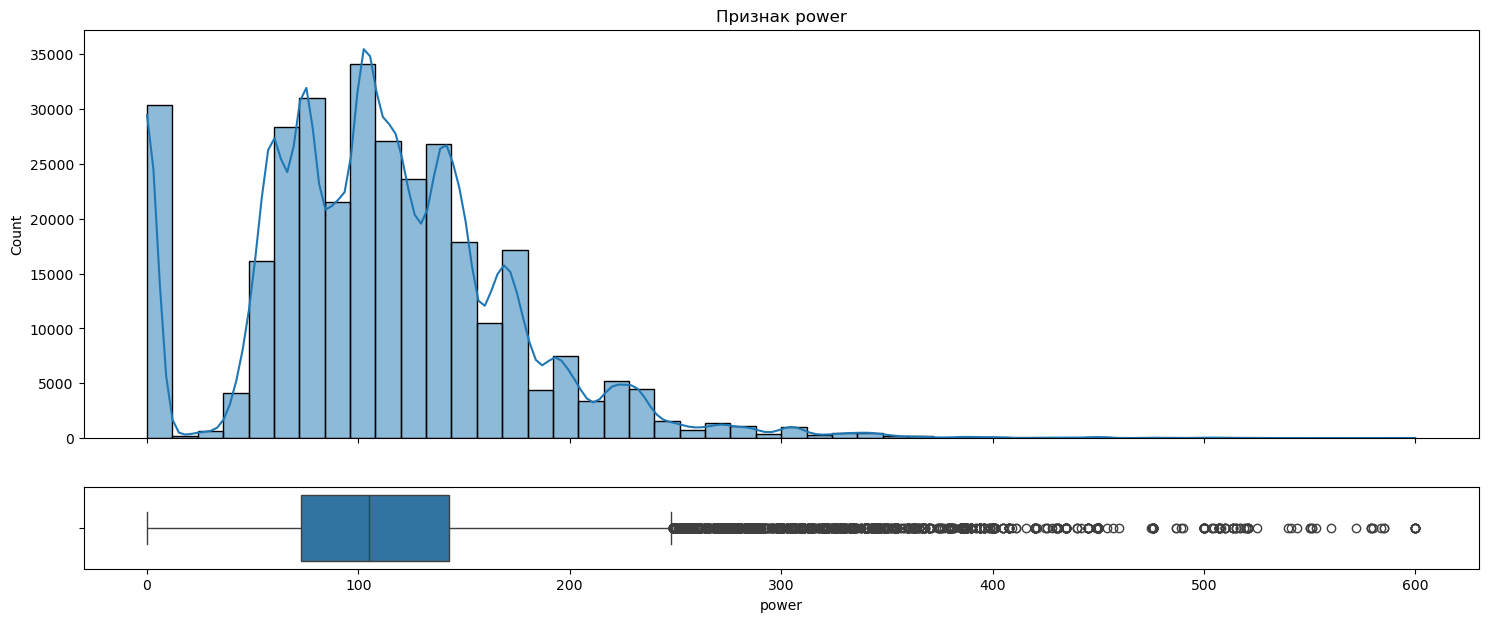

In [133]:
# вызовим ф-ю build_hist_box()
build_hist_box(df_filter, 'power')

Смущает вплеск около нуля, возможно это старые автомибли, либо ошибка при заполнении, попробуем оставить минимальную мощность начиная с 25 л.с., так как обнаружили, что по медиане минимальная мощность 26 л.с. была у автомобиля модели `601` компании `trabant`.

In [135]:
# Удаляем машины с мощностью менее 25
df_filter = df_filter[df_filter['power'] > 25]

In [136]:
df_filter.power.describe().to_frame()

,power
count,291937.000000
mean,121.048000
std,53.785835
min,26.000000
25%,77.000000
50%,113.000000
75%,150.000000
max,600.000000


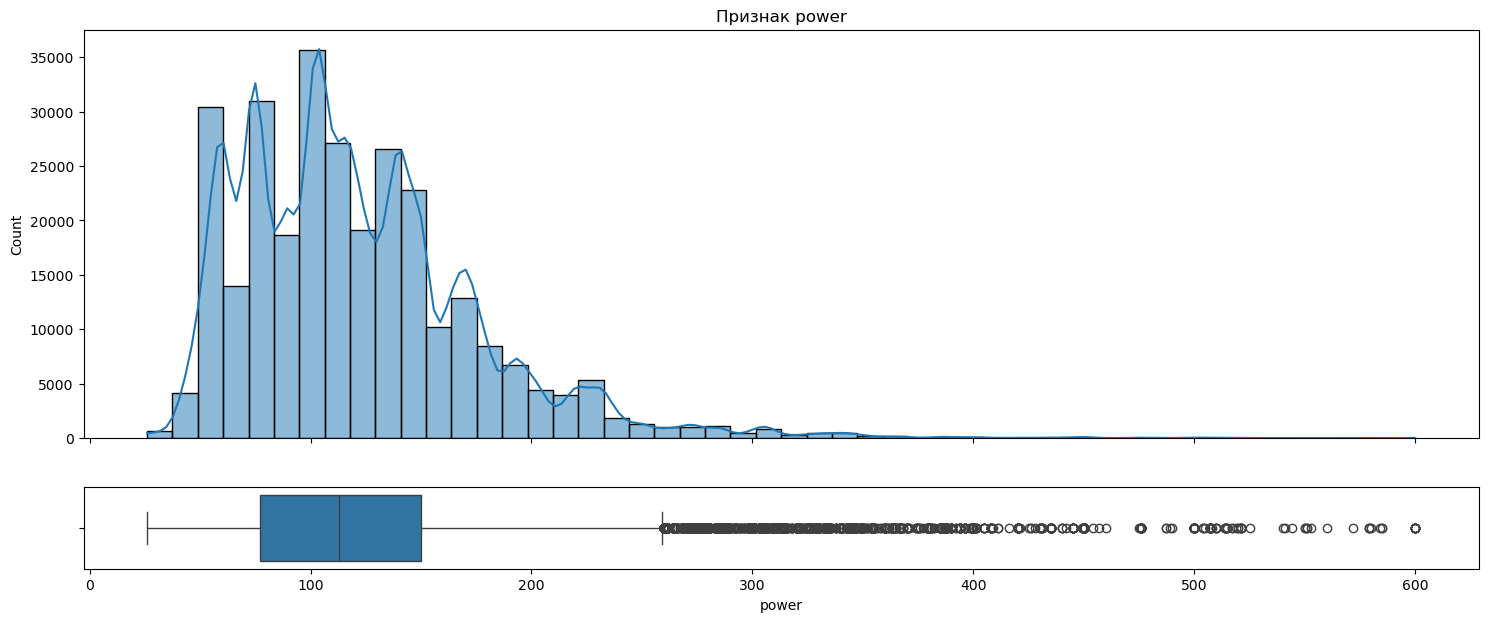

In [137]:
# вызовим ф-ю build_hist_box()
build_hist_box(df_filter, 'power')

Стало лучше, хотя мощные машины и походят на выбросы среди остальных, но думаю данную особенность стоит учитывать при предсказании цены. 

Если конечно приложение для предсказания цен на машину рассчитано только для средних или бюджетных машин, то да, лучше убрать сильно мощные машины, но будем считать что приложение должно быть достаточно универсально.

In [139]:
# оценим коэфф. Пирсона
df_filter['price'].corr(df_filter['power'])

0.5099254808750596

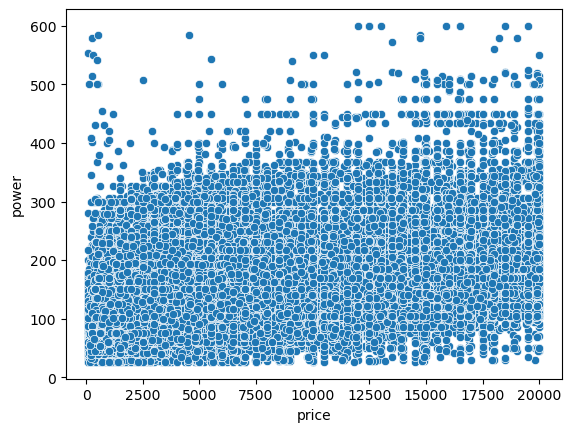

In [140]:
sns.scatterplot(data=df_filter, x='price', y='power')
plt.show()

Умеренная прямая связь цены и мощности автомобиля. Не всегда можно сказать, что чем больше мощность, тем выше цена, так как у машин с пробегом техническое состояние не маловажный фактор.

#### `model`

Посмотрим самые популярные модели. Обработаем пропуски.

In [144]:
# популярные модели
df_filter[['model']].value_counts(dropna = False, normalize = True)*100

model             
golf                  8.297681
other                 6.890528
3er                   5.900588
NaN                   3.585363
polo                  3.583307
                        ...   
kalina                0.001713
samara                0.001713
serie_3               0.001028
rangerover            0.000685
range_rover_evoque    0.000685
Name: proportion, Length: 250, dtype: float64

In [145]:
# популярные модели
df_filter.pivot_table(index = ['brand', 'model'], values = 'date_created', aggfunc = 'count').sort_values(by = 'date_created', ascending = False).head(10)

date_created
brand         model                 
volkswagen    golf             24224
bmw           3er              17226
volkswagen    polo             10461
opel          corsa             9886
              astra             8926
audi          a4                8737
volkswagen    passat            8711
mercedes_benz c_klasse          7289
bmw           5er               7059
mercedes_benz e_klasse          5902

In [146]:
# кол-во пропусков в столбце 'model' у разных брендов
df_filter[df_filter['model'].isna() == True]['brand'].value_counts()

brand
volkswagen        1927
sonstige_autos    1628
opel              1065
bmw               1054
audi               707
mercedes_benz      629
ford               528
peugeot            494
renault            388
fiat               251
mazda              185
smart              127
seat               126
citroen            124
nissan             115
hyundai            112
mitsubishi          94
toyota              94
honda               88
skoda               76
kia                 73
alfa_romeo          72
volvo               69
suzuki              69
chevrolet           60
chrysler            51
rover               39
mini                38
trabant             30
daewoo              25
subaru              22
jeep                17
daihatsu            15
lancia              15
porsche             15
dacia               13
saab                10
land_rover          10
jaguar               6
lada                 6
Name: count, dtype: int64

In [147]:
# кол-0о уникальны моделей машин у разных брендов
for i in df_filter['brand'].unique():
    uniq_model = len(df_filter.loc[(df_filter['brand'] == i) & (df_filter['model'].isna() == False), 'model'].unique())
    print(f'Компания {i} кол-во уникальных моделей = {uniq_model}')

Компания audi кол-во уникальных моделей = 16
Компания jeep кол-во уникальных моделей = 4
Компания volkswagen кол-во уникальных моделей = 22
Компания skoda кол-во уникальных моделей = 7
Компания bmw кол-во уникальных моделей = 10
Компания peugeot кол-во уникальных моделей = 6
Компания ford кол-во уникальных моделей = 14
Компания mazda кол-во уникальных моделей = 8
Компания nissan кол-во уникальных моделей = 9
Компания renault кол-во уникальных моделей = 10
Компания mercedes_benz кол-во уникальных моделей = 18
Компания seat кол-во уникальных моделей = 10
Компания honda кол-во уникальных моделей = 5
Компания fiat кол-во уникальных моделей = 10
Компания opel кол-во уникальных моделей = 16
Компания mini кол-во уникальных моделей = 4
Компания smart кол-во уникальных моделей = 4
Компания alfa_romeo кол-во уникальных моделей = 6
Компания subaru кол-во уникальных моделей = 5
Компания volvo кол-во уникальных моделей = 9
Компания mitsubishi кол-во уникальных моделей = 7
Компания kia кол-во уникал

Заполнять пропуски модой для каждой компании не рацианально, так как они выпускают достаточно разнообразные модели. Заполним пропуски 'unknow'.

In [149]:
# заполним пропуски 'unknow'
fill_pass(df_filter, 'model', 'unknow')

In [150]:
df_filter['model'].isna().sum()

0

In [151]:
# оцени медианное значение цены на машины для разных моделей 
df_filter.pivot_table(index = ['brand', 'model'], values = 'price', aggfunc = 'median').sort_values(by = 'price', ascending = False)

,,price
brand,model,
mercedes_benz,gl,18999.0
volkswagen,amarok,18677.5
audi,q3,18499.0
mercedes_benz,glk,17900.0
audi,a5,16700.0
...,...,...
daewoo,unknow,650.0
mazda,1_reihe,600.0
lada,samara,600.0


Модель машины влияет на цену, что вринципе логично.

#### `kilometer`

In [154]:
df_filter[['kilometer']].describe()

,kilometer
count,291937.000000
mean,128331.369439
std,36600.486128
min,5000.000000
25%,125000.000000
50%,150000.000000
75%,150000.000000
max,150000.000000


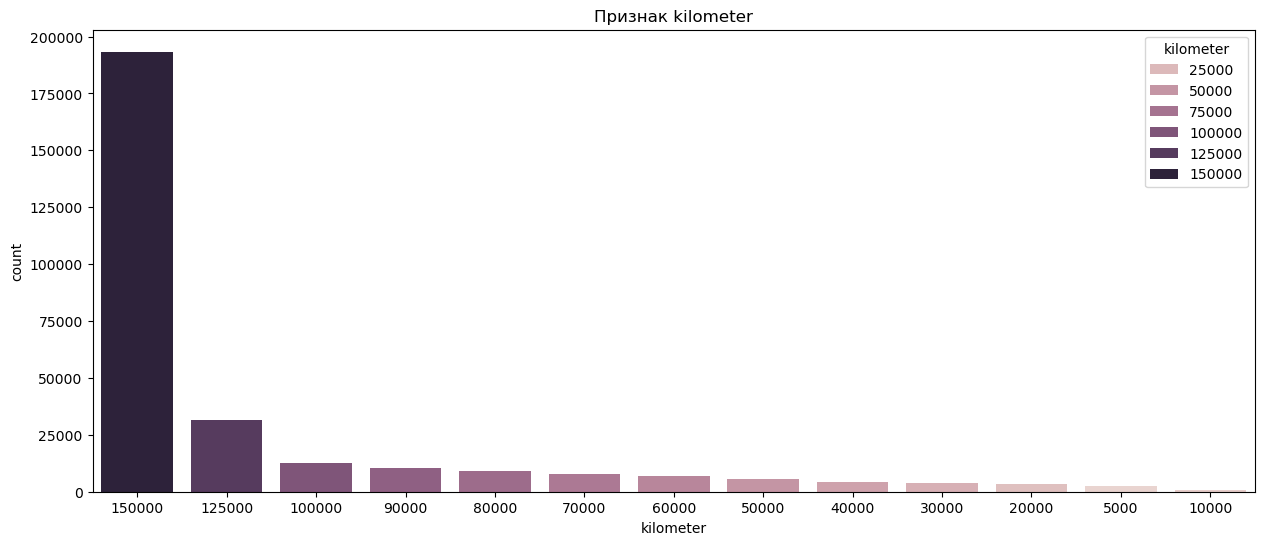

In [155]:
# посмотрим какой пробег у машин
build_barplot(df_filter, 'kilometer')

In [156]:
# оценим медианное значение пробега у разных брендов
df_filter.pivot_table(index = 'brand', values = 'kilometer', aggfunc = 'median').sort_values(by = 'kilometer', ascending = False)

,kilometer
brand,
alfa_romeo,150000.0
porsche,150000.0
mazda,150000.0
audi,150000.0
mitsubishi,150000.0
nissan,150000.0
opel,150000.0
peugeot,150000.0
renault,150000.0


Машины с малым пробегом редкость, большинство продаются с пробегом больше 100 тыс.км.

Возможно просто сформировался такой рынок, что люди начинают массово продавать машины с пробегом больше 100 тыс.км, так как начинает ломаться. Непонятно, как обстоят дела с большими пробегами, видимо данные скачались только до 150 тыс.км.

In [158]:
# оцени медианное значение цены на машины для разного пробега
df_filter.pivot_table(index = 'kilometer', values = 'price', aggfunc = 'median').sort_values(by = 'price', ascending = False)

,price
kilometer,
10000,11900.0
20000,9600.0
30000,9500.0
40000,9500.0
50000,8700.0
60000,8000.0
70000,7400.0
80000,6700.0
90000,5800.0


Хмм, в целом связь ясна, чем больше пробег, тем меньше стоимость, но пробег 5000 тыс.км выходит за рамки.

In [160]:
# оценим по кол-ву ремонтов машины с малым пробегом и низкой ценой 
df_filter[(df_filter['kilometer'] == 5000) & (df_filter['price'] < 5000)]['repaired'].value_counts(dropna = False)

repaired
no     841
NaN    686
yes    287
Name: count, dtype: int64

Здесь непонятно, но возможно машины с малым пробегом и уже в ремонте явно сбивают цену вниз.

In [162]:
df_filter[df_filter['kilometer'] == 5000]['price'].describe()

count     2570.000000
mean      4328.263813
std       4926.068158
min        100.000000
25%        842.250000
50%       2100.000000
75%       6150.000000
max      20000.000000
Name: price, dtype: float64

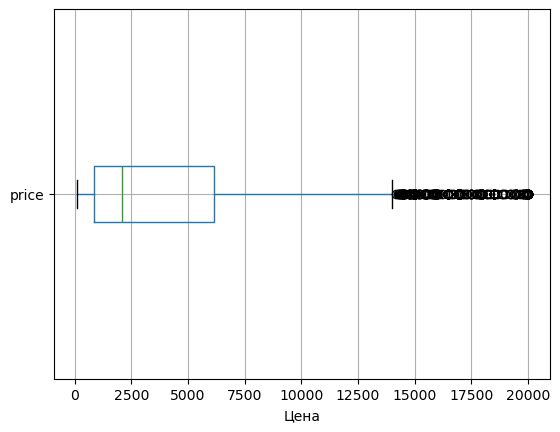

In [163]:
df_filter[df_filter['kilometer'] == 5000][['price']].boxplot(vert = False)
plt.xlabel('Цена')
plt.show()

Вообщем, машины с пробегом 5000 тыс.км должны быть в среднем дороже, но что-то пошло не так. Возможно это какие-то браки, после аварии, или просто дешевые авто модели.

#### `registration_month`

In [166]:
df_filter.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknow,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07


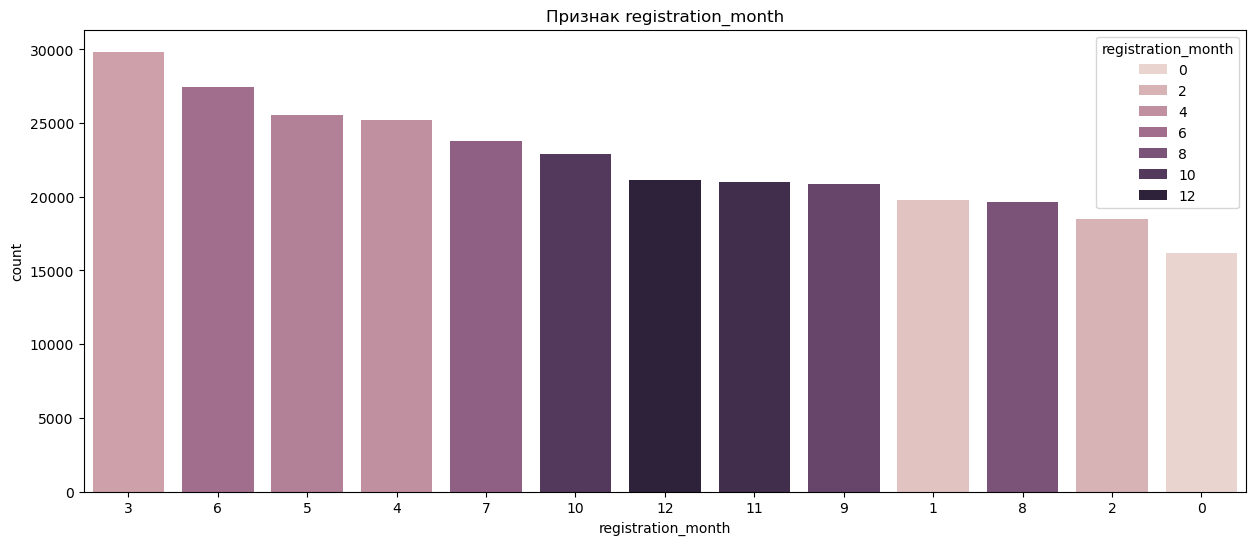

In [167]:
# построим гистгормму распределения месяца регистрации
build_barplot(df_filter, 'registration_month')

In [168]:
# оцени медианное значение цены на машины для разных месяцев регистрации
df_filter.pivot_table(index = 'registration_month', values = 'price', aggfunc = 'median').sort_values(by = 'price', ascending = False)

,price
registration_month,
11,3600.0
9,3550.0
4,3500.0
10,3500.0
7,3450.0
6,3399.0
8,3397.0
12,3350.0
1,3300.0


Хмм, всего 12 месяцев, у нас получается 13. Либо человеский фактор, либо какая-то техничекая ошибка. Возможно 0 месяц это январь, но нет четких оснований. В целом цены по месяцам не сильно отличаются, а вот в 0 месяца как раз сильно, это явно какая - то ошибка.

Данный признак не будет полезен для объяснения вариации в цене, поэтому его впринципе можно и не учитывать

#### `fuel_type	`

Посмотрим каким топливом пользуются. Обработаем пропуски.

In [172]:
df_filter['fuel_type'].value_counts(normalize = True)

fuel_type
petrol      0.666349
gasoline    0.314039
lpg         0.016753
cng         0.001725
hybrid      0.000720
other       0.000288
electric    0.000126
Name: proportion, dtype: float64

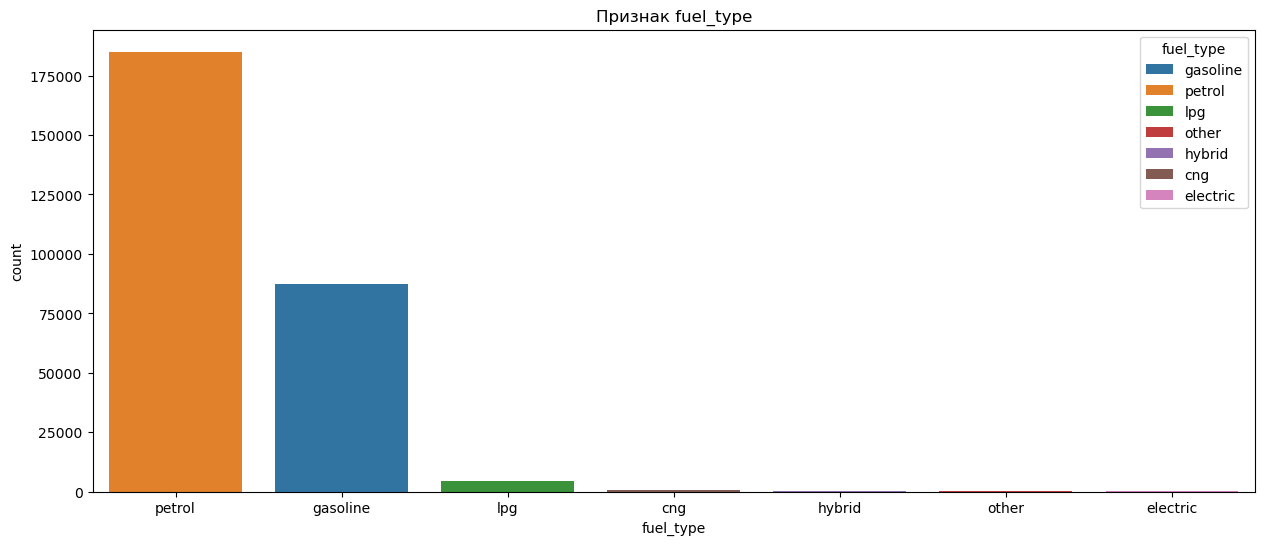

In [173]:
# построим гистгормму распределения вида топлива
build_barplot(df_filter, 'fuel_type')

In [174]:
df_filter.pivot_table(index = 'model', columns = 'fuel_type', values = 'brand', aggfunc = 'count').head(10)

fuel_type,cng,electric,gasoline,hybrid,lpg,other,petrol
model,,,,,,,
100,NaN,NaN,13.0,NaN,7.0,NaN,323.0
145,NaN,NaN,NaN,NaN,NaN,NaN,33.0
147,NaN,NaN,120.0,NaN,13.0,NaN,346.0
156,NaN,NaN,164.0,NaN,15.0,NaN,318.0
159,NaN,NaN,133.0,NaN,NaN,NaN,54.0
1_reihe,NaN,NaN,36.0,NaN,4.0,NaN,974.0
1er,NaN,NaN,1568.0,NaN,9.0,NaN,1662.0
200,NaN,NaN,NaN,NaN,NaN,NaN,15.0
2_reihe,NaN,NaN,512.0,NaN,27.0,NaN,3630.0


In [175]:
df_filter.pivot_table(index = 'brand', columns = 'fuel_type', values = 'date_crawled', aggfunc = 'count').head(10)

fuel_type,cng,electric,gasoline,hybrid,lpg,other,petrol
brand,,,,,,,
alfa_romeo,NaN,NaN,554.0,NaN,30.0,NaN,1270.0
audi,NaN,2.0,11128.0,NaN,417.0,1.0,12745.0
bmw,6.0,3.0,11134.0,NaN,678.0,3.0,18747.0
chevrolet,4.0,NaN,215.0,NaN,166.0,NaN,1019.0
chrysler,NaN,NaN,328.0,NaN,84.0,NaN,685.0
citroen,5.0,1.0,1405.0,NaN,61.0,NaN,2552.0
dacia,2.0,NaN,183.0,NaN,49.0,NaN,527.0
daewoo,NaN,NaN,1.0,NaN,21.0,NaN,360.0
daihatsu,NaN,1.0,4.0,NaN,4.0,NaN,555.0


Бензин явно лидирует. Здесь также не совсем рационально заполнять пропуски просто модой, так как одно топливо один двигатель, другой вид топливо другой вид двигателя и цены соответственно будут разные. Какие - то модели или бренды имеют только один вид топлива, но это явно единичные случаи.

Так как у каждой модели преоладает тот или иной вид топлива заполним пропуски в соотиветсвии с модой для каждой модели, там где модель неизвестна заполнмим модой по бренду.

In [177]:
model_fuel_type = df_filter.groupby('model')['fuel_type'].apply(lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()
brand_fuel_type = df_filter.groupby('brand')['fuel_type'].apply(lambda x: x.mode()[0]).to_dict()

In [178]:
def fill_fuel_type(row):
    if pd.isna(row['fuel_type']):
        
        if row['model'] in model_fuel_type and model_fuel_type[row['model']] is not None:
            return model_fuel_type[row['model']]
            
        elif row['brand'] in brand_fuel_type:
            return brand_fuel_type[row['brand']]
            
    return row['fuel_type']

In [179]:
df_filter['fuel_type'] = df_filter.apply(fill_fuel_type, axis = 1)

In [180]:
df_filter['fuel_type'].value_counts(normalize = True)

fuel_type
petrol      0.674878
gasoline    0.306463
lpg         0.015938
cng         0.001641
hybrid      0.000685
other       0.000274
electric    0.000120
Name: proportion, dtype: float64

In [181]:
df_filter['fuel_type'].isna().sum()

0

Пропуски обработали. Незначительно изменилась доля petrol и gasoline.

In [183]:
# оцени медианное значение цены на машины для разных видов топлива
df_filter.pivot_table(index = 'fuel_type', values = 'price', aggfunc = 'median').sort_values(by = 'price', ascending = False)

,price
fuel_type,
hybrid,10900.0
electric,9800.0
gasoline,5699.0
cng,4000.0
lpg,3100.0
petrol,2350.0
other,1650.0


Логика прослеживается, двигатели на бензиновом двигателе и вравду дешевле, бензин правда дорогой...

#### `brand`

Оценим популярные компании, сделаем выводы.

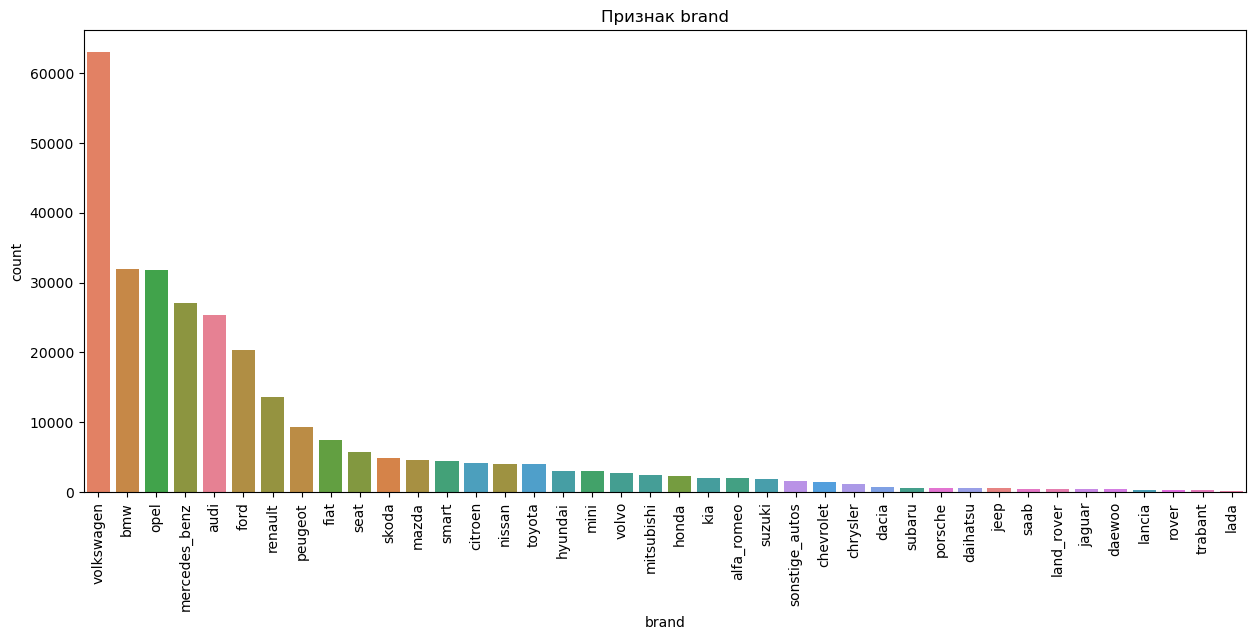

In [187]:
# построим гистгормму распределения брендов
build_barplot(df_filter, 'brand')
plt.xticks(rotation=90)
plt.show()

In [188]:
# оцени медианное значение цены на машины для разных компаний
df_filter.pivot_table(index = 'brand', values = 'price', aggfunc = 'median').sort_values(by = 'price', ascending = False)

,price
brand,
porsche,12500.0
land_rover,8900.0
mini,8500.0
sonstige_autos,6800.0
jeep,6500.0
bmw,5500.0
jaguar,5500.0
audi,5499.0
skoda,5200.0


Явно есть связь цены и бренда. Некоторые компании производят больше бюджетных машин для не боготых людей, какие-то наоборот.

#### `repaired`

Оценим как много машин с ремонтом. Обработаем пропуски.

In [192]:
df_filter.repaired.value_counts(dropna = False, normalize = True)

repaired
no     0.763298
NaN    0.140595
yes    0.096106
Name: proportion, dtype: float64

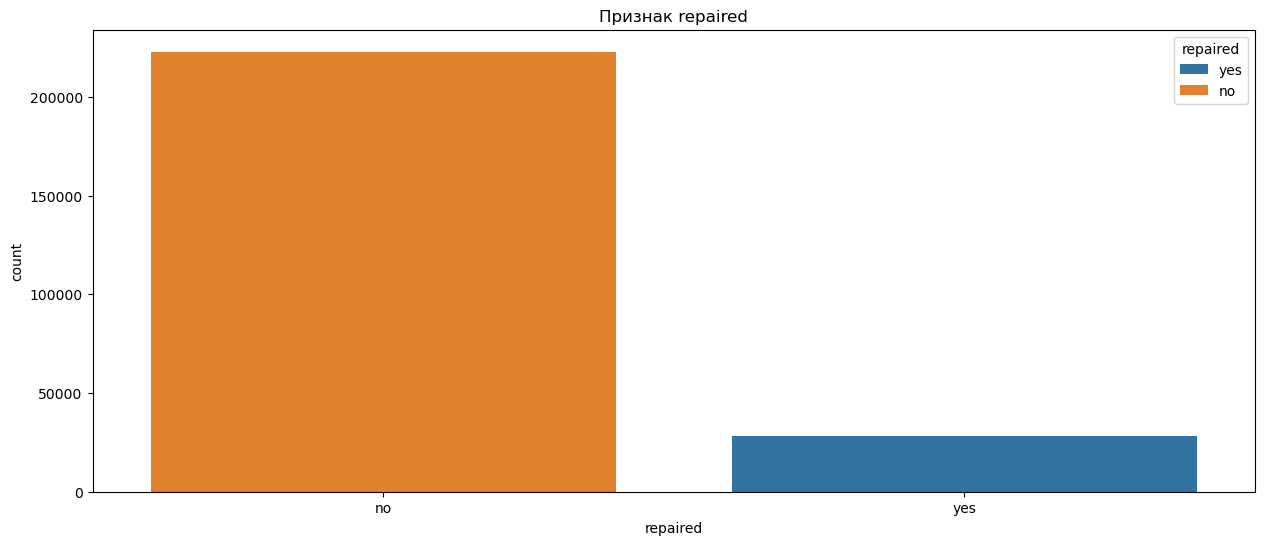

In [193]:
# построим столбчатую диаграмму, оцени кол-во машин с ремонтом и без него
build_barplot(df_filter, 'repaired')

In [194]:
# оцени медианное значение цены на машины c ремонтом и без него
df_filter.pivot_table(index = 'repaired', values = 'price', aggfunc = 'median').sort_values(by = 'price', ascending = False)

,price
repaired,
no,3990.0
yes,1100.0


Наличие ремонта явно влияет на цену машины. Пропуски заполним 'unknow'.

In [196]:
# вызовим ф-ю для заполнения пропусков
fill_pass(df_filter, 'repaired', 'unknow')

In [197]:
df_filter.repaired.isna().sum()

0

#### `date_created`

Оценим дату создания анкеты.

In [200]:
df_filter[['date_created']].describe()

,date_created
count,291937
mean,2016-03-20 19:21:55.282406656
min,2015-03-20 00:00:00
25%,2016-03-13 00:00:00
50%,2016-03-21 00:00:00
75%,2016-03-29 00:00:00
max,2016-04-07 00:00:00


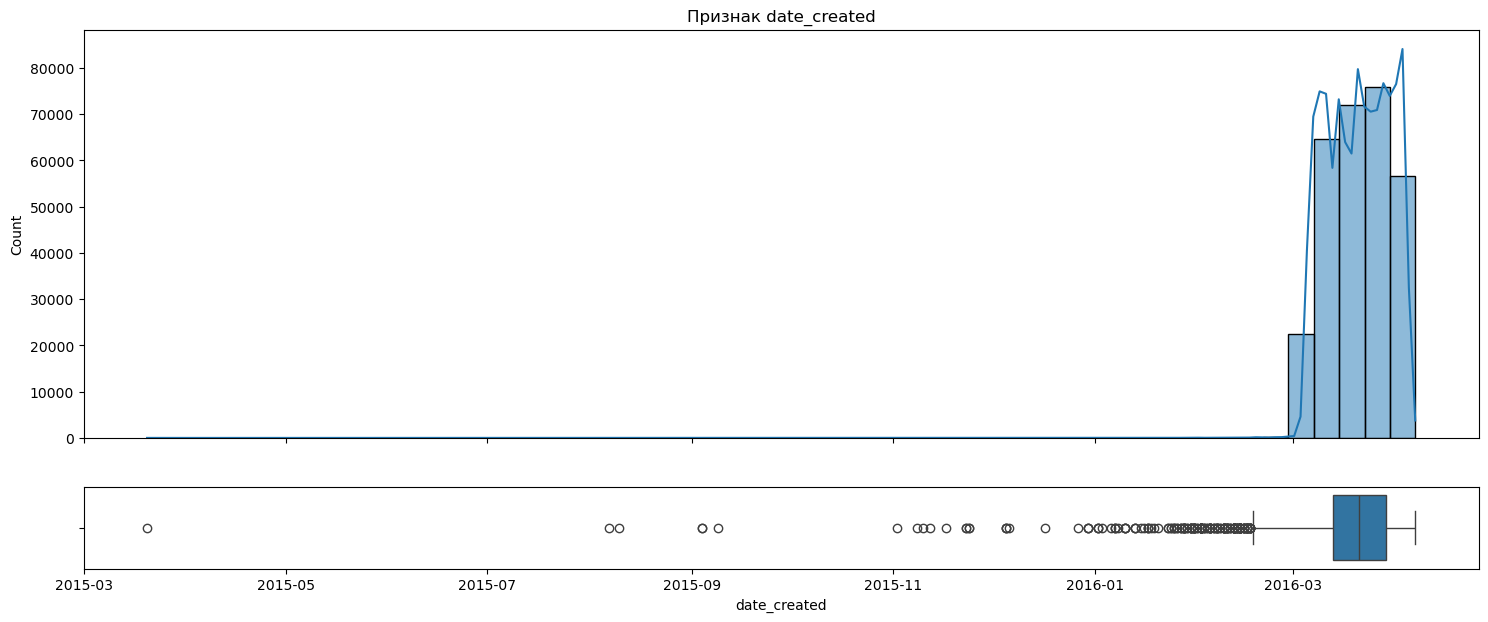

In [201]:
build_hist_box(df_filter, 'date_created')

В целом ничего особенного, единственное несколько записей за 2015 год, но их не так много. За несколько лет уровень цен мог существенно измениться,  в нашем случае единичные наблюдения за прошлые года скорее вносят шум, проще удалить такие данные.

In [203]:
df_filter = df_filter[df_filter['date_created'].dt.year > 2015]

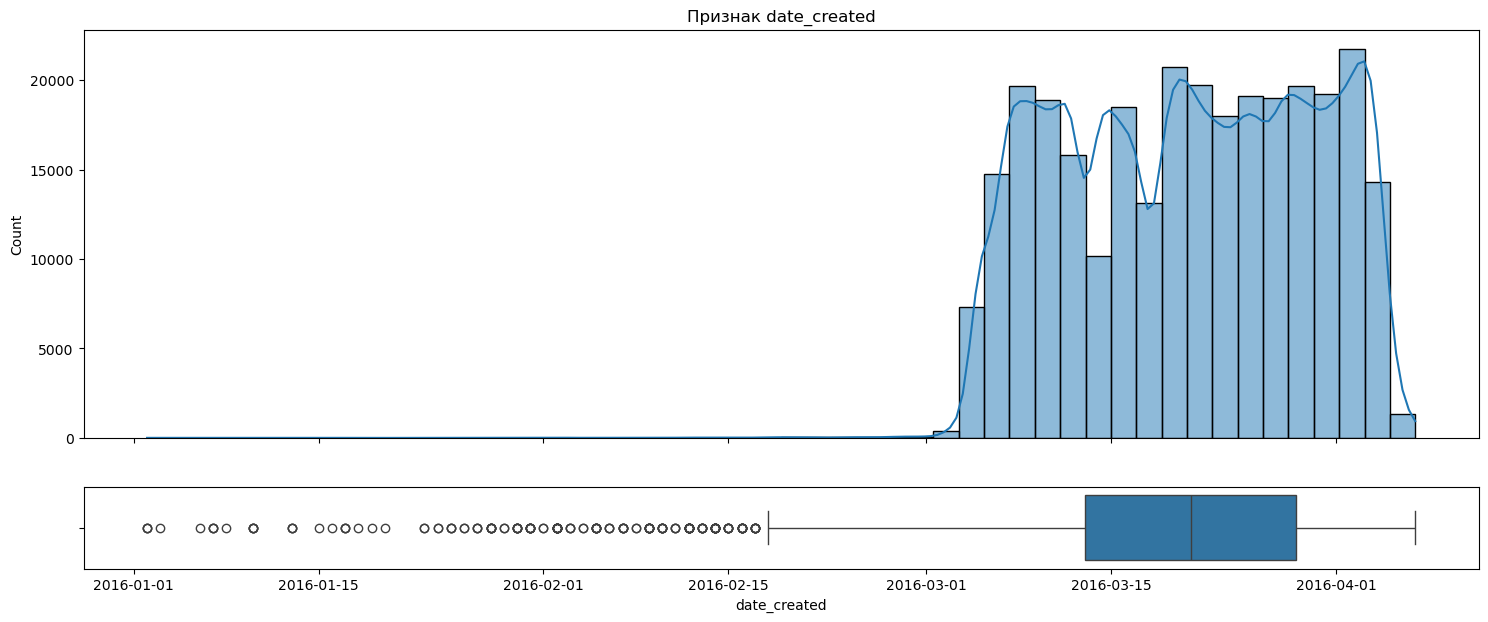

In [204]:
build_hist_box(df_filter, 'date_created')

#### `number_of_pictures`

In [206]:
df_filter.number_of_pictures.value_counts()

number_of_pictures
0    291913
Name: count, dtype: int64

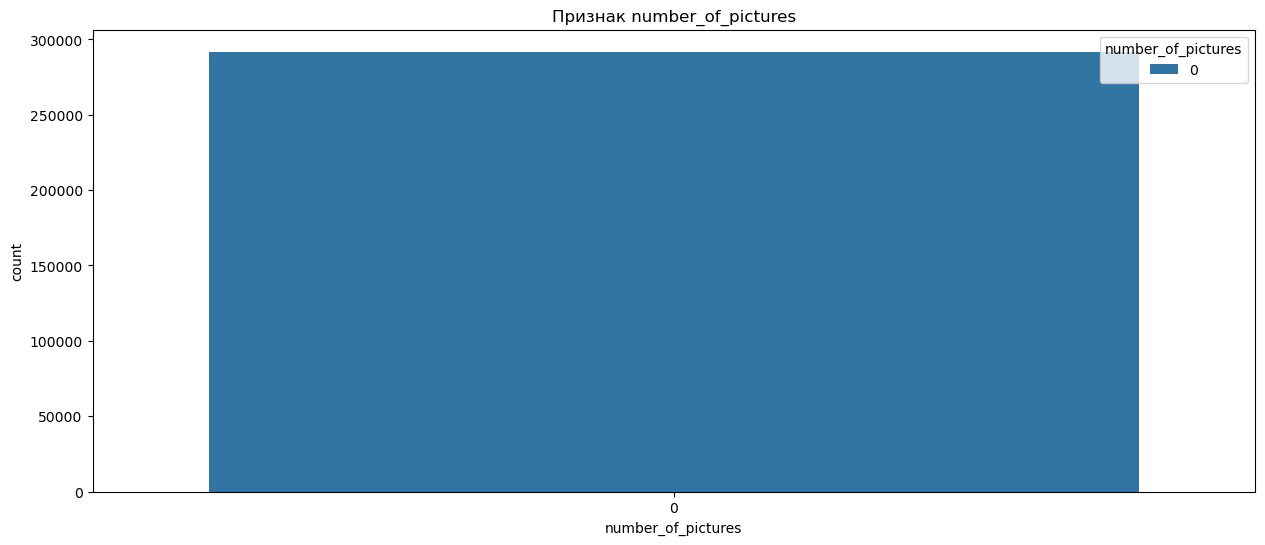

In [207]:
# построим столбчатую диаграмму, оцени кол-во машин с ремонтом и без него
build_barplot(df_filter, 'number_of_pictures')

Ни одной фотки нет. Возможно технические ошибки при скачивании, либо действительно нет данных. Вообще хоть несколько фото на машину должно быть, возможно они фактически есть, но надо искать, считать, проверять, а информации очень много и так скажем пока что не реализовали способ как всё быстро и точно подсчитать и заполнили столбец '0'.

Данный признак врядли бы нам пригодился для обучения модели.

#### `postal_code`

Исследуем почтовые индексы.

In [211]:
df_filter.postal_code.value_counts().head()

postal_code
10115    798
65428    498
66333    270
60311    261
52525    246
Name: count, dtype: int64

In [212]:
df_filter.postal_code.nunique()

8111

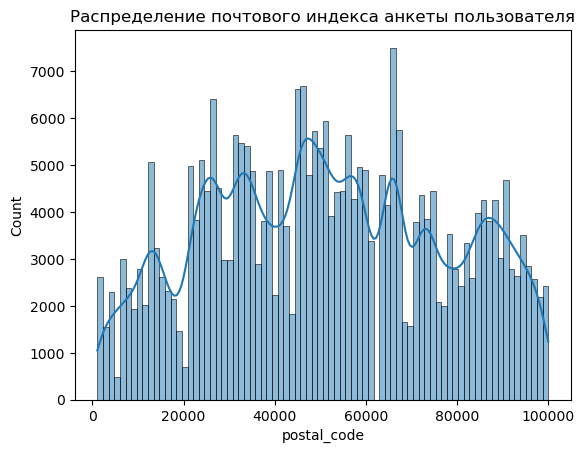

In [213]:
plt.title('Распределение почтового индекса анкеты пользователя')
sns.histplot(df_filter.postal_code, kde = True)
plt.show()

8111 уникальный пользователей. Некоторые из них продают много машин, скорей всего это автосалоны, либо какие-то ИП.

#### `last_seen`

In [216]:
df_filter[['last_seen']].describe()

,last_seen
count,291913
mean,2016-03-30 05:42:43.566339840
min,2016-03-05 14:15:08
25%,2016-03-23 14:45:13
50%,2016-04-04 04:18:04
75%,2016-04-06 10:46:57
max,2016-04-07 14:58:51


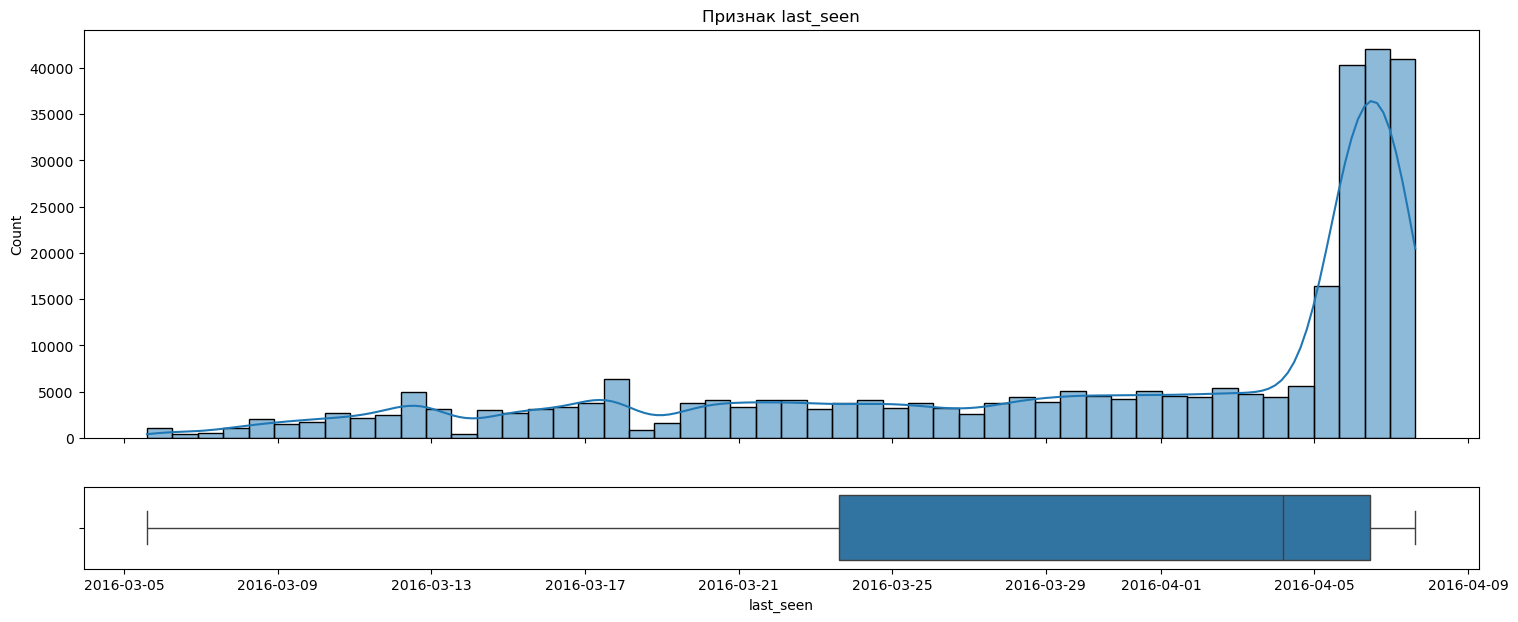

In [217]:
build_hist_box(df_filter, 'last_seen')

В целом ничего осбенного. 5 - 7  апреля наибольшая активность пользовтателей.

### Корреляционный анализ

In [220]:
# воспользуемся методом phik_matrix для определения корреляции количественных и категориальных признаков
phik_overview = phik_matrix(df_filter.drop(columns = ['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen']), 
                            interval_cols= ['price', 'power']
                           )

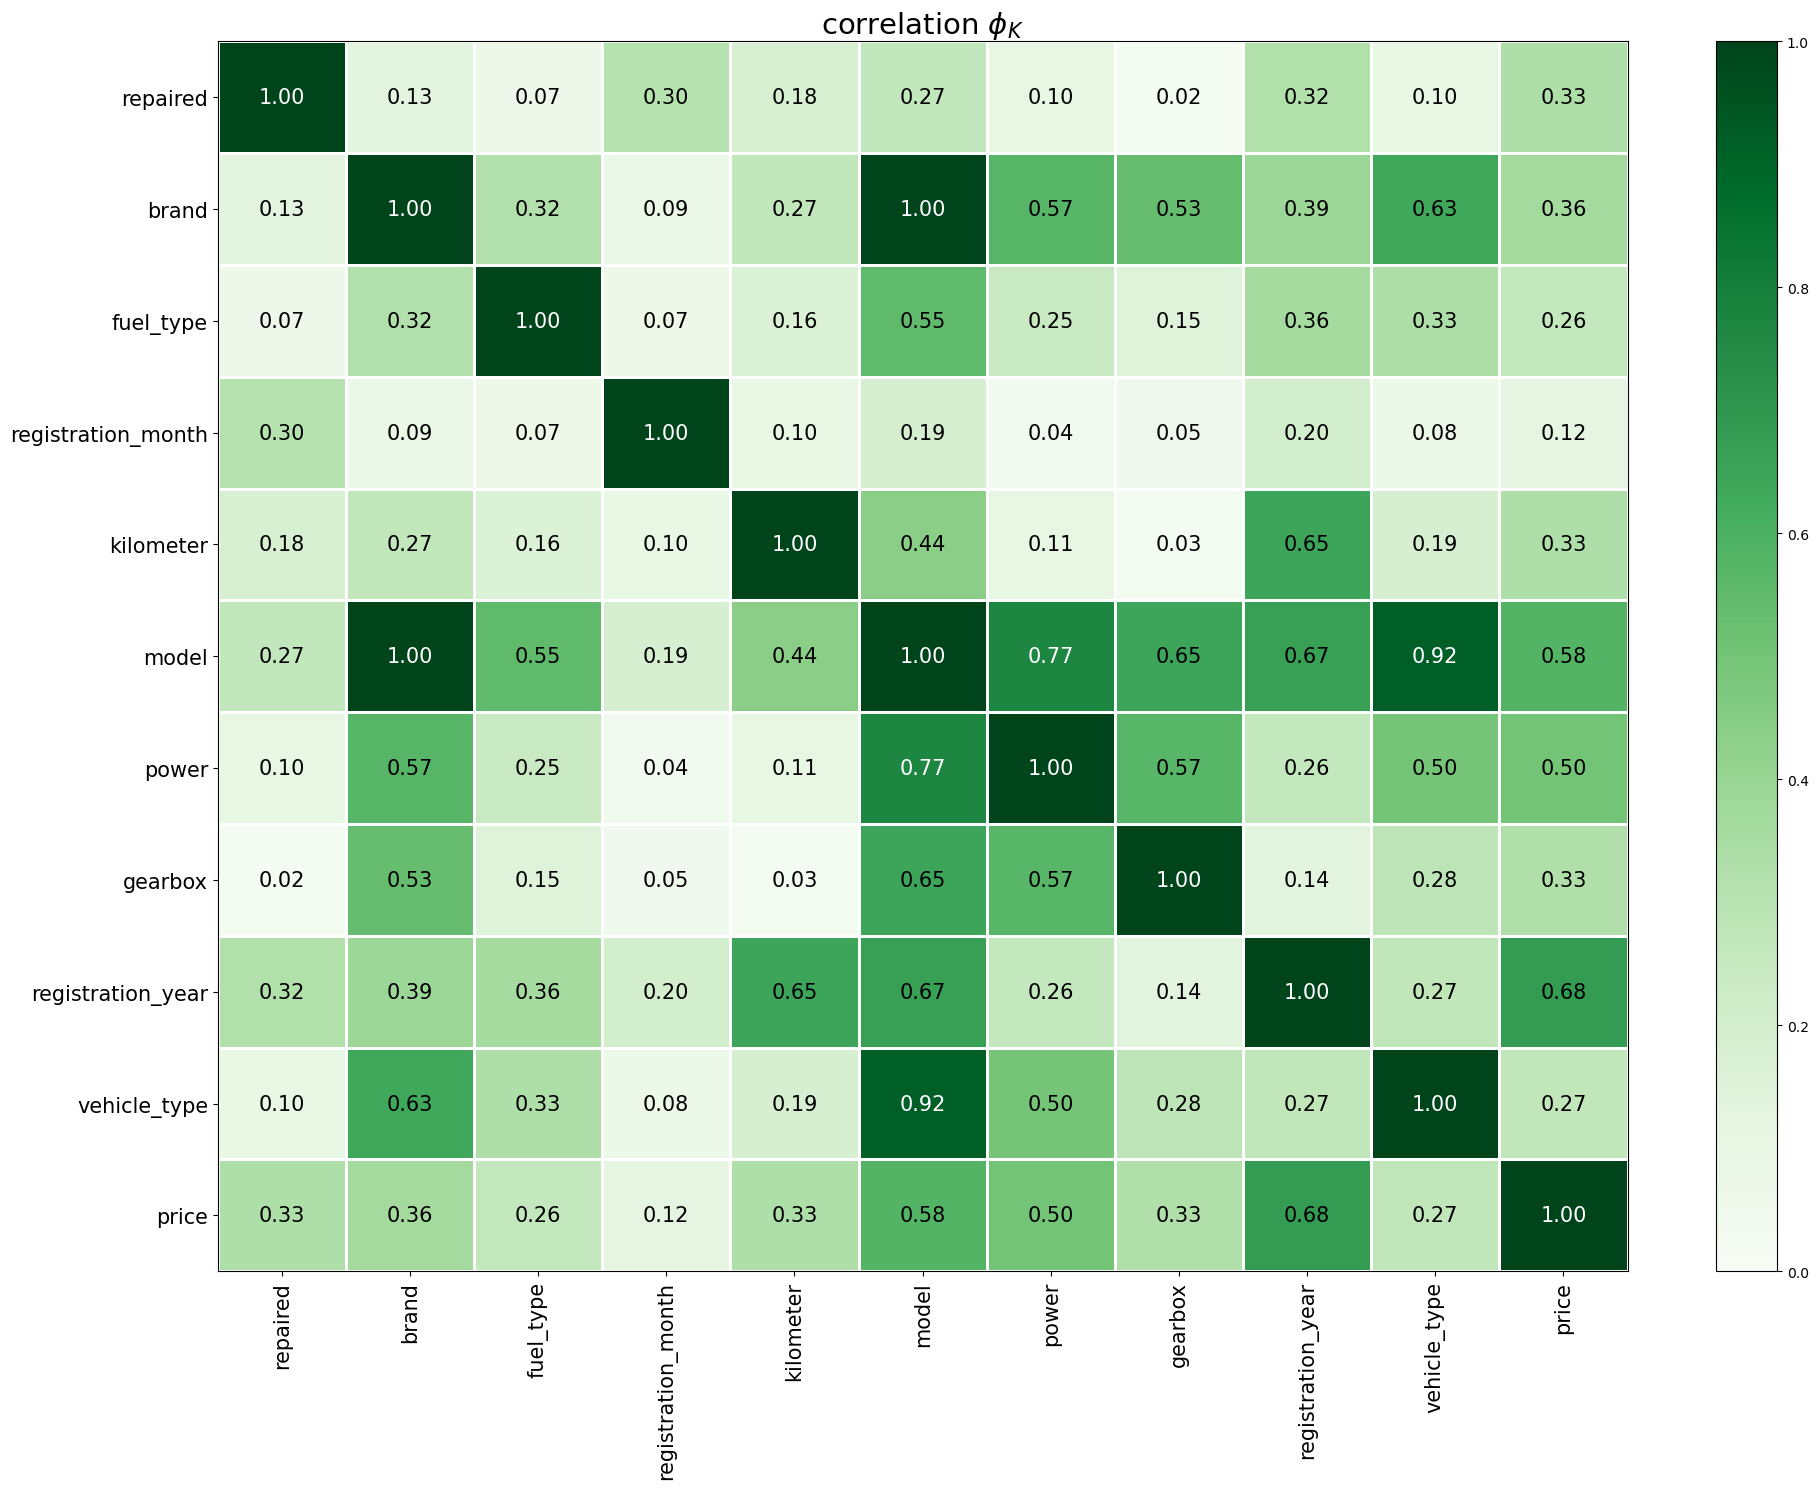

In [221]:
# построим матрицу корреляци между всеми признаками
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Мультиколленирность между признаками `model` и `brand`. Возможно стоит оставить только признак `model`, так как у каждого бренда свои уникальные модели и будет очевидно, что одна модель соответвует одному бренду.

Между признакми `model` и `vehicle_type` весьма высокая прямая связь, но всё-таки модели могут иметь разный тип кузова.

При обучени модели будем учитывать данные особенности, и по надобности корректировать признаки.

### Вывод

Мы провели исследовательский анализ, сделали предобрботку данных. 

Основные моменты:

- Изменили названия столбцов
- Удалили явные дубликаты в кол-ве 4 шт.
- Поменяли тип данных на datetime для столбцов с датами
- По столбцу `price` удалили 4% данных с слишком низкими ценами
- По столбцу `vehicle_type` пропуски заполнили 'unknow', у разных типов кузовов разные цены
- По столбцу `registration_year` удалили аномальные значения, прослеживается связь чем старей машина тем ниже её цена
- По столбцу `gearbox` пропуски заполнили 'unknow', стоимость машин с АКПП по медиане больше, 76% машин с МКПП
- По столбцу `power` удалили аномальные значения, оставили диапазон 25-600 л.с. 
- По столбцу `model` пропуски заполнили 'unknow', самая популярная модель 'golf' компании 'Volkswagen', разная ценовая категоря у разныз моделей
- По столбцу `kilometer`, чем больше пробег тем меньше цена, в основом машины с пробегом > 100 тыс.км.
- По столбцу `registration_month` выброс в виде месяца = '0', медианное значение цены по месяцам не сильно отличается
- По столбцу `fuel_type` пропуски заполнили 'unknow', по мединному значению цены 'hybrid' и 'electric' самые дорогие, самые дешевые `petrol` и `other`
- По столбцу `repaired` пропуски заполнили 'unknow', по мединному значению цены машины с ремонтом дешевле
- Удалили строки заполненные только значениями 'unknow'
- Мультиколленирность между признаками `model` и `brand`

Исходя из анализа, выберем признаки для обучения модели:

['vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'fuel_type', 'repaired']

Но при обучении попробуем добавить `brand` для сравненя качества.

## Обучение модели 

Обучим несколько моделей градиентного бустинига, поробуем применить другие модели.

Для оценки качества моделей применем метрику RMSE. 

Условия качества модели: RMSE < 2500.

In [227]:
# Подготовим тренировочную, валидационную и тестовую выборку в соотношении 60:20:20 %
X = df_filter.drop(columns = ['date_crawled', 'registration_month', 
                              'date_created', 'number_of_pictures', 
                              'postal_code', 'last_seen', 'price'])
y = df_filter['price']

X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.25, 
    random_state=RANDOM_STATE) 

In [228]:
# создадим функцию для метрик rmse
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### CatBoostRegressor

In [230]:
# Создадим отдельную ф-ю для CatBoostRegressor()
def train_model_ctbr(model, params_model, X_train, y_train):
    
    randomized_search = RandomizedSearchCV(
        model, 
        params_model, 
        cv=3,
        scoring='neg_root_mean_squared_error',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    # обучаем модель на тренировочных данных
    randomized_search.fit(X_train, y_train)

    # Лучшая модель
    best_model = randomized_search.best_estimator_
    best_score = randomized_search.best_score_

    return randomized_search

In [231]:
# Гиперпараметры для модели CatBoostRegressor()
catboost_params = {
    'iterations': [5, 10, 20, 50, 100, 150],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}
cat_columns = ['gearbox', 'repaired', 'vehicle_type', 'model', 'fuel_type', 'brand']


In [232]:
%%time
catboost_model = train_model_ctbr(CatBoostRegressor(loss_function='RMSE', verbose=50, random_state=RANDOM_STATE, cat_features = cat_columns), 
                             catboost_params, 
                             X_train, y_train)

0:	learn: 4312.5487710	total: 298ms	remaining: 29.5s
50:	learn: 1848.3961810	total: 6.75s	remaining: 6.49s
99:	learn: 1741.5247109	total: 12.9s	remaining: 0us
CPU times: total: 45.1 s
Wall time: 3min 12s


In [233]:
# среднее время обучения в секундах
fit_time_ctbr = catboost_model.cv_results_['mean_fit_time'][catboost_model.best_index_]
print(fit_time_ctbr)

30.96767020225525


In [234]:
# среднее время оценки в секундах
score_time_ctbr = catboost_model.cv_results_['mean_score_time'][catboost_model.best_index_]
print(score_time_ctbr)

0.7303898334503174


In [235]:
# RMSE при кросс-валидации
rmse_ctbr = (catboost_model.best_score_)*(-1)
print(rmse_ctbr)

1755.7033064859472


In [236]:
print(f'Время обучения модели: {fit_time_ctbr.round(2)} сек.')
print(f'Время предсказания: {score_time_ctbr.round(2)} сек.')
print(f'Значение метрики RMSE при кросс-валидации: {rmse_ctbr.round(2)}')

Время обучения модели: 30.97 сек.
Время предсказания: 0.73 сек.
Значение метрики RMSE при кросс-валидации: 1755.7


### LGBMRegressor

In [238]:
def train_model_lgbm(model, params_model, X_train, y_train):
    # Указываем категориальные признаки (должны быть предварительно преобразованы в тип 'category')
    categorical_features = ['gearbox', 'repaired', 'vehicle_type', 'model', 'fuel_type', 'brand']
    
    # Преобразуем категориальные признаки в тип 'category' (если они ещё не в этом формате)
    for col in categorical_features:
        if col in X_train.columns:
            X_train[col] = X_train[col].astype('category')
    
    # Создаём итоговый пайплайн
    pipe_final = Pipeline(
        [
            ('models', model)
        ]
    )
    
    # Настройка RandomizedSearchCV для поиска гиперпараметров
    randomized_search = RandomizedSearchCV(
        pipe_final, 
        params_model, 
        cv=5,
        scoring='neg_root_mean_squared_error',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    # Обучаем модель на тренировочных данных
    randomized_search.fit(X_train, y_train)

    return randomized_search

In [239]:
# Гиперпараметры для модели LGBMRegressor()
lgbm_params = {
    'models__num_leaves': [31, 50, 100, 150],
    'models__learning_rate': [0.01, 0.05, 0.1],
    'models__n_estimators': [5, 10, 20, 50, 100],
    'models__min_child_samples': [20, 30, 50]
}

In [240]:
%%time
# обучаем модель LGBMRegressor()
lgbm_model = train_model_lgbm(LGBMRegressor(random_state=RANDOM_STATE, force_row_wise=True, verbose=0), lgbm_params, X_train, y_train)

CPU times: total: 6.2 s
Wall time: 44.1 s


In [241]:
# RMSE при кросс-валидации
rmse_lgbm = (lgbm_model.best_score_)*(-1)

In [242]:
# среднее время обучения в секундах
fit_time_lgbm = lgbm_model.cv_results_['mean_fit_time'][lgbm_model.best_index_]
print(fit_time_lgbm)

5.594021415710449


In [243]:
# среднее время оценки в секундах
score_time_lgbm = lgbm_model.cv_results_['mean_score_time'][lgbm_model.best_index_]
print(score_time_lgbm)

0.3756294250488281


In [244]:
print(f'Время обучения модели: {fit_time_lgbm.round(2)} сек.')
print(f'Время предсказания: {score_time_lgbm.round(2)} сек.')
print(f'Значение метрики RMSE при кросс-валидации: {rmse_lgbm.round(2)}')

Время обучения модели: 5.59 сек.
Время предсказания: 0.38 сек.
Значение метрики RMSE при кросс-валидации: 1555.27


### RandomForestRegressor

In [246]:
# созданим функцию для обучения моделей 
def train_model_tree(model, params_model, X_train, y_train):
    # создаём списки с названиями признаков для кодирования и мастабирования
    cat_columns = ['gearbox', 'repaired', 'vehicle_type', 'model', 'fuel_type', 'brand']

    # используем OrdinalEncoder() для кодирования категориальных признаков
    te_pipe = Pipeline([('te', TargetEncoder())])

    # создаём общий пайплайн для подготовки данных
    data_preprocessor = ColumnTransformer(
        transformers = [('cat', te_pipe, cat_columns)], 
        remainder='passthrough'
    )
    
    # создаём итоговый пайплайн: подготовка данных и модель
    pipe_final = Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('models', model)
        ]
    )
    # создаем словарь набора парамеров модели
    param_grid = params_model
    
    # Настройка RandomizedSearchCV для поиска гиперпараметров
    randomized_search = RandomizedSearchCV(
        pipe_final, 
        param_grid, 
        cv=5,
        scoring='neg_root_mean_squared_error',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    # обучаем модель на тренировочных данных
    randomized_search.fit(X_train, y_train)

    return randomized_search

In [247]:
# Гиперпараметры для модели RandomForestRegressor()
rfg_params = {
    'models__max_features': [3, 5],
    'models__min_samples_leaf': [1, 3, 5],
    'models__max_depth': [1, 3, 5]
}

In [248]:
%%time
rfg_model = train_model_tree(RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1, oob_score=True), rfg_params, X_train, y_train)

CPU times: total: 42.7 s
Wall time: 4min 16s


In [249]:
# RMSE при кросс-валидации
rmse_rfg = (rfg_model.best_score_)*(-1)
print(rmse_rfg)

2158.2094708507743


In [250]:
# среднее время обучения в секундах
fit_time_rfg = rfg_model.cv_results_['mean_fit_time'][rfg_model.best_index_]
print(fit_time_rfg)

33.64051294326782


In [251]:
# среднее время оценки в секундах
score_time_rfg = rfg_model.cv_results_['mean_score_time'][rfg_model.best_index_]
print(score_time_rfg)

1.068684196472168


In [252]:
print(f'Время обучения модели: {fit_time_rfg.round(2)} сек.')
print(f'Время предсказания: {score_time_rfg.round(2)} сек.')
print(f'Значение метрики RMSE при кросс-валидации: {rmse_rfg.round(2)}')

Время обучения модели: 33.64 сек.
Время предсказания: 1.07 сек.
Значение метрики RMSE при кросс-валидации: 2158.21


### DummyRegressor

Проверим адекватность всех моделей, сравнивая с обычной DummyRegressor().

In [256]:
dummy_model = train_model_tree(DummyRegressor(),{}, X_train, y_train)

C:\Users\кц\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [257]:
# RMSE при кросс-валидации
(dummy_model.best_score_)*(-1)

4620.606826662499

In [260]:
# среднее время обучения в секундах
dummy_model.cv_results_['mean_fit_time'][dummy_model.best_index_]

1.6821263313293457

In [262]:
# среднее время оценки в секундах
dummy_model.cv_results_['mean_score_time'][dummy_model.best_index_]

0.09400820732116699

На простой модели метрика RSME значительно хуже, значит модели градиентного бустинга и бэггинга сделали свою работу.

### Анализ моделей

Мы обучили 4 разных моделей, все дали разные результаты. На основании критерий, которые важны заказчику:
1) качество предсказания;
2) время обучения модели;
3) время предсказания модели,

выберем наиболее подходящее.

In [267]:
values_models = {'CatBoostRegressor' : [fit_time_ctbr, score_time_ctbr, rmse_ctbr], 
                 'LGBMRegressor' : [fit_time_lgbm, score_time_lgbm, rmse_lgbm],
                 'RandomForestRegressor' : [fit_time_rfg, score_time_rfg, rmse_rfg]
                }


In [269]:
result_models = pd.DataFrame(data = values_models, index = ['Время обучения', 'Время предсказания', 'RMSE'])

In [271]:
result_models

,CatBoostRegressor,LGBMRegressor,RandomForestRegressor
Время обучения,30.967670,5.594021,33.640513
Время предсказания,0.730390,0.375629,1.068684
RMSE,1755.703306,1555.273624,2158.209471


Выберем LGBMRegressor, так как она победила по всем критериям заказчика, среди остальных. Проверим её качестов на тествой выборке.

In [288]:
# Преобразуем категориальные признаки в тип 'category' (если они ещё не в этом формате)
categorical_features = ['gearbox', 'repaired', 'vehicle_type', 'model', 'fuel_type', 'brand']
for col in categorical_features:
    if col in X_test.columns:
        X_test[col] = X_test[col].astype('category')

In [290]:
# Предсказания и оценка модели LGBMRegressor() на тестовой выборке
pred_lgbm_test = lgbm_model.best_estimator_.predict(X_test)

# Оценка метрки RMSE
rmse_lgbm_test = rmse(y_test, pred_lgbm_test)
print(rmse_lgbm_test)

1544.7504344917138


RMSE < 2500, условие выполняется. 

In [293]:
# среднее значение ошибок
(y_test - pred_lgbm_test).mean()

-7.509857404263788

Модель склонна предсказывать цену на машину больше, чем она есть на самом деле.

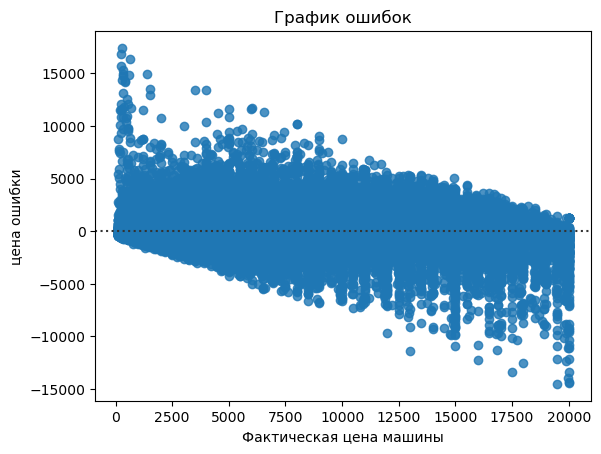

In [296]:
# график ошибок
plt.title('График ошибок')
sns.residplot(x = y_test, y = pred_lgbm_test).set(xlabel = 'Фактическая цена машины', ylabel = 'цена ошибки')
plt.show()

Модель силно ошибается при малых ценах и высоких. Возможно не совсем удачно подобраны признаки, обработаны неправильно выбросы, или выбраны не те параметры модели.

Скорей всего, в датасете остались какие-то выбросы, н-р в среднем цена б/у машины лада 200 000 рублей, но кто-то решил её продать за 500 000 рублей, потому что у неё доработана система трансмиссии, установлен новый тип мощного двигателя...вообщем такие случаи сильно искажают картину и модель как раз может из за этого ошибаться.

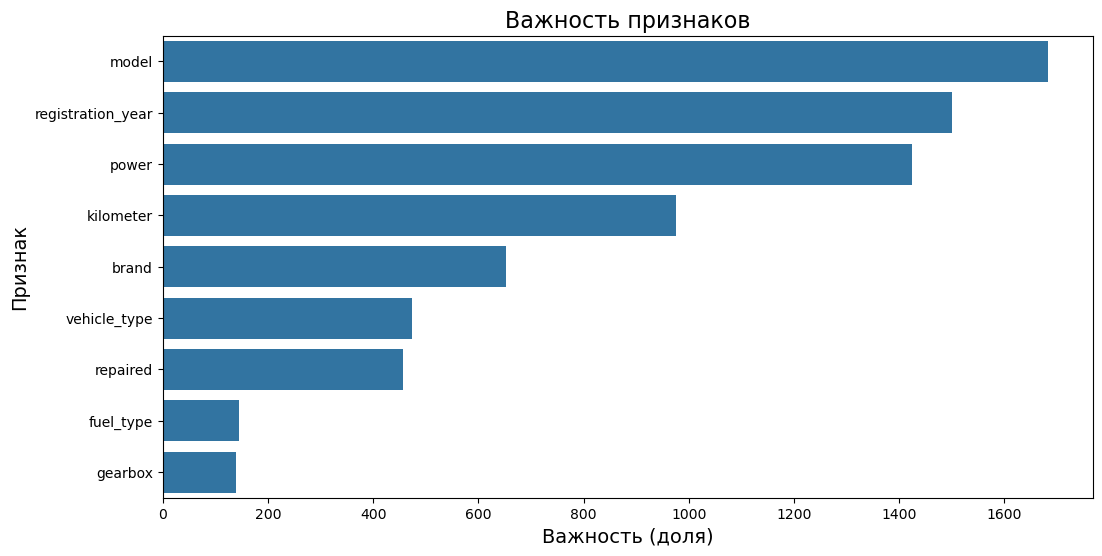

In [307]:
# формируем таблицу важности признаков и сортируем её
feature_importances = pd.DataFrame(
    {
        'Feature': X_train.columns,
        'Importance': lgbm_model.best_estimator_['models'].feature_importances_
    }).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))

# Построим столбчатый график:
# по оси x — важность признака;
# по оси y - его наименование.
ax = sns.barplot(data=feature_importances, x='Importance', y='Feature')

# добавляем названия графика и осей
ax.set_title('Важность признаков', fontsize=16)
ax.set_xlabel('Важность (доля)', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)

# отображаем график
plt.show()

Наибольший вклад внесли ряд признаков `model`, `registration_year`, `power` что впринцпе потдвержается при исследовательском анализе данных. Поэтому важно, чтобы пользователь корректно вводил признаки повышенной важности, в противном случаи наиболее точно цену его автомобиля будет сложней определить.

## Вывод

Компания разрабатывает приложение, чтобы привлечь новых клиентов, в котором можно будет узнать рыночную стоимость своего автомобиля. 

Перед нами была задача создать такую модель, которая умеет определять такую цена. 

Критерии, которые важны заказчику:
 - качество предсказания;
 - время обучения модели;
 - время предсказания модели.

Для нас был предоствалены данные о технических характеристиках, комплектации и ценах других автомобилей.

Мы проверили предобработку и исследовательский анализ данных, было много различных проблем, выделили основные моменты:
- Удалили явные дубликаты в кол-ве 4 шт.
- По столбцу `price` удалили 4% данных с слишком низкими ценами
- По столбцу `vehicle_type` пропуски заполнили модой для каждой отдельной модели и бренда.
- По столбцу `registration_year` удалили аномальные значения, прослеживается связь чем старей машина тем ниже её цена
- По столбцу `gearbox` пропуски заполнили модой для каждой отдельной модели и бренда, стоимость машин с АКПП по медиане больше, 76% машин с МКПП
- По столбцу `power` удалили аномальные значения, оставили диапазон 25-600 л.с. 
- По столбцу `model` пропуски заполнили 'unknow', самая популярная модель 'golf' компании 'Volkswagen', разная ценовая категоря у разныз моделей
- По столбцу `kilometer`, чем больше пробег не всегда меньше цена, видимо старые машины рассматриваются как раритет, в основом машины с пробегом > 100 тыс.км.
- По столбцу `registration_month` выброс в виде месяца = '0', медианное значение цены по месяцам не сильно отличается
- По столбцу `fuel_type` пропуски заполнили модой для каждой отдельной модели и бренда, по мединному значению цены 'hybrid' и 'electric' самые дорогие, самые дешевые `petrol` и `other`
- По столбцу `repaired` пропуски заполнили 'unknow', по мединному значению цены машины с ремонтом дешевле.

После того как подготовили данные, разделили их на тренировочную, тестовую выборку в соотношении 80/20% соответсвенно.

Обучили модели CatBoostRegresso, LGBMRegressor, RandomForestRegressor на тренировочной выборке и оценили качество RMSE на кросс-валидации. 

Наиболее успешная модель оказалсь LGBMRegressor с характеристиками:

In [312]:
result_models[['LGBMRegressor']]

,LGBMRegressor
Время обучения,5.594021
Время предсказания,0.375629
RMSE,1555.273624


Рекомендации для бизнес: Наибольший вклад в предсказание цена машины внесли ряд признаков `model`, `registration_year`, `power`, `kilometr`. Важно, чтобы пользватель корректно вводил данные параметры своего автомобиля, в противном случае цена будет предсказана не точно. Также модель обучалась на старых данных, поэтому для будущих годов, модель будет не верно предсказывать цену, так как экономика меняется с каждым годом, цены на топливо, металл могут значительно колебаться, что будет влиять на стоимость машины. Важно дополнительлно учитывать экономические показатели для корректного предсказания цены.